<a href="https://colab.research.google.com/github/MohammadAghaei1/Plantdoc-image-processing/blob/main/Plantdoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

freezing model layer head (csl and dfl)
check images size with padding True and false
wrong detection in background (background in confusion matrix)
learning rate

# **Importing Dataset**

In [1]:
!git clone https://github.com/MohammadAghaei1/Plantdoc-image-processing

Cloning into 'Plantdoc-image-processing'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 152 (delta 63), reused 0 (delta 0), pack-reused 35 (from 1)
Receiving objects: 100% (152/152), 124.19 MiB | 21.52 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [2]:
!unzip /content/Plantdoc-image-processing/Dataset/PlantDoc\ 416x416.zip

Archive:  /content/Plantdoc-image-processing/Dataset/PlantDoc 416x416.zip
 extracting: train/Faske%20Southern%20rust%20of%20corn_jpg.rf.016116db58617610bb259b2965f41589.jpg  
 extracting: train/Slide1_preview_jpg.rf.00f57cfc188631c10e10e2b93a38d296.jpg  
 extracting: train/2017-08-27%2B-%2BLate%2BBlight%2Bon%2BGypsy%2B1_jpg.rf.00584c9d14b6fda3086f9a482675d610.jpg  
 extracting: train/Apple-Scab-image-02_jpg.rf.00cbc9a108dbdaadf4232b5392e3d3c8.jpg  
 extracting: train/24154194959_fd4b42edde_b_jpg.rf.0012f9978a300c5635840700fa784280.jpg  
 extracting: train/2-3%20Gray%20leaf%20spot%20BRUCE_jpg.rf.0040c2e382cf11216938e6f49b7d65ed.jpg  
 extracting: train/Septoria_tomato_Margaret%20B_p8170755_0002_25004_jpg.rf.00ddfef2668a53da256f207f9b844782.jpg  
 extracting: train/d-to-tylv-fo005-14496A31BE70553130A_jpg.rf.017e4558f1b4baeadc32a13beb178a6e.jpg  
 extracting: train/Bacterial-spot-symptoms-on-pepper-leaves-for-web_jpg.rf.01bc16f3b7ba0e4c9fa8c07133a723c6.jpg  
 extracting: train/IMG_6029-00

In [3]:
import os
import csv
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# **Data Preparation**

**Defining pathes into variables**

In [4]:
#Train
train_annotation_broken  = '/content/train/_annotations.csv'
train_annotation_clean   = '/content/train/_annotations_clean.csv'
train_images_old = '/content/train'
train_images_new = '/content/train/images'
train_images_separated = '/content/train/images_by_class'
train_splitted_csv = '/content/train/train_annotations.csv'
train_yolo_labels = '/content/train/labels'

#test
test_annotation_broken  = '/content/test/_annotations.csv'
test_annotation_clean   = '/content/test/_annotations_clean.csv'
test_images_old = '/content/test'
test_images_new = '/content/test/images'
test_yolo_labels = '/content/test/labels'

#Validation
val_annotation_clean   = '/content/val/val_annotations.csv'
val_images_old = '/content/val'
val_images_new = '/content/val/images'
val_yolo_labels = '/content/val/labels'

yaml_path = '/content/data.yaml'

**Train Data**

**Some lines have problem in their names so before reading csv should repair them**

In [5]:
def find_problematic_lines(path):

    problematic_lines = []
    expected_cols = 8
    with open(path, 'r') as f:
        reader = csv.reader(f)
        # Skip the header row
        header = next(reader)
        for i, row in enumerate(reader):
            if len(row) != expected_cols:
                problematic_lines.append((i + 2, row))

    problematic_root = path.replace('_annotations.csv', '')

    if problematic_lines:
        # Save to the test folder
        with open(problematic_root+'problematic_lines.csv', 'w', newline='') as outfile:
            writer = csv.writer(outfile)
            writer.writerow(['Line Number', 'Problematic Row Content'])
            for line_num, row_content in problematic_lines:
                writer.writerow([line_num, ','.join(row_content)])

        print(f"Found {len(problematic_lines)} problematic lines. Details saved to '{problematic_root}problematic_lines.csv'.")
        print(f"Please review '{problematic_root}problematic_lines_train.csv' and fix the data in the original file.")
    else:
        print("No problematic lines found in the annotation file.")

**All the rows was fixed but just 10 of them was the emtpy and they didnt have considrable informations**

In [6]:
def repair_csv(csv_path):

    ANNOTATIONS = Path(csv_path)
    ENCODING    = "utf-8-sig"
    OUT_CLEAN   = ANNOTATIONS.with_name(ANNOTATIONS.stem + "_clean.csv")
    OUT_BAD     = ANNOTATIONS.with_name(ANNOTATIONS.stem + "_unfixable.csv")
    EXPECTED_HEADER = ["filename","width","height","class","xmin","ymin","xmax","ymax"]


    def is_int_token(s: str) -> bool:
        s = s.strip()
        if s.startswith(("+","-")): s = s[1:]
        return s.isdigit()

    def first_consecutive_int_pair(tokens):
        """return index i where tokens[i] and tokens[i+1] are both ints; else None"""
        for i in range(len(tokens) - 1):
            if is_int_token(tokens[i]) and is_int_token(tokens[i+1]):
                return i
        return None

    def rebuild_row(tokens):
        """
        tokens: list obtained by naive comma split via csv.reader
        returns (ok, row_or_reason)
        row format: [filename,width,height,class,xmin,ymin,xmax,ymax]
        """
        toks = [t.strip() for t in tokens if t is not None]

        # 1) locate width,height as the first consecutive int pair
        w_idx = first_consecutive_int_pair(toks)
        if w_idx is None:
            return False, "no consecutive width,height integers found"

        filename = ",".join(toks[:w_idx]).strip().strip('"')
        width, height = toks[w_idx], toks[w_idx + 1]
        rest = toks[w_idx + 2:]

        # Need at least 5 tokens after height (some class + 4 bbox ints)
        if len(rest) < 5:
            return False, "not enough fields after height"

        # 2) pick the LAST 4 integer tokens in 'rest' -> bbox
        bbox_indices = []
        for j in range(len(rest) - 1, -1, -1):
            if is_int_token(rest[j]):
                bbox_indices.append(j)
                if len(bbox_indices) == 4:
                    break
        if len(bbox_indices) != 4:
            return False, "could not find 4 bbox integers in tail"
        bbox_indices.sort()
        xmin, ymin, xmax, ymax = [rest[k] for k in bbox_indices]

        # 3) class = everything between height and earliest bbox int
        class_tokens = rest[:bbox_indices[0]]
        if not class_tokens:
            return False, "class field missing"
        class_name = ",".join(class_tokens).strip().strip('"')

        return True, [filename, width, height, class_name, xmin, ymin, xmax, ymax]

    def main():
        fixed, bad = [], []

        with ANNOTATIONS.open(encoding=ENCODING, newline="") as f:
            rdr = csv.reader(f)
            _ = next(rdr, None)  # skip original header if present
            for row in rdr:
                ok, out = rebuild_row(row)
                if ok:
                    fixed.append(out)
                else:
                    bad.append({"reason": out, "raw": ",".join(row)})

        # Write clean file
        with OUT_CLEAN.open("w", newline="", encoding=ENCODING) as f:
            w = csv.writer(f)
            w.writerow(EXPECTED_HEADER)
            w.writerows(fixed)

        # Write any unfixable rows for manual check
        with OUT_BAD.open("w", newline="", encoding=ENCODING) as f:
            w = csv.writer(f)
            w.writerow(["reason","raw_line"])
            for br in bad:
                w.writerow([br["reason"], br["raw"]])

        print(f" Clean rows written: {len(fixed)} -> {OUT_CLEAN}")
        print(f" Unfixable empty rows: {len(bad)} -> {OUT_BAD}")

    if __name__ == "__main__":
        main()


**Put all images in train fodler to train/images**

In [7]:
def move_images_to_correct_folder(source_dir, destination_dir):

    import os
    import shutil

    source_dir = source_dir
    destination_dir = destination_dir

    # Create the destination directory if it doesn't exist
    os.makedirs(destination_dir, exist_ok=True)

    # List all files in the source directory
    all_files = os.listdir(source_dir)

    moved_count = 0
    for filename in all_files:
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, filename)

        # Check if the file is a file (not a directory) and if it has a .jpg extension
        if os.path.isfile(source_path) and filename.lower().endswith('.jpg'):
            try:
                shutil.move(source_path, destination_path)
                moved_count += 1
            except Exception as e:
                print(f"Error moving {filename}: {e}")

    print(f"Moved {moved_count} image files from {source_dir} to {destination_dir}")

**Check all unique names in annotation file to be in train folder**

In [8]:
def check_unique_annotation_image(annotation_path, images_path ):

    import os
    import pandas as pd
    from pathlib import Path

    # Load the cleaned training annotations CSV file
    cleaned_annotations_path = annotation_path
    cleaned_annotation_df = pd.read_csv(cleaned_annotations_path)

    # Get the set of unique filenames from the CSV
    csv_filenames = set(cleaned_annotation_df['filename'].unique())

    # Get the set of image filenames from the directory
    train_images_dir = images_path
    # List files in the directory and get their base names
    image_files = set([f for f in os.listdir(train_images_dir) if os.path.isfile(os.path.join(train_images_dir, f))])


    # Find the filenames that are in the CSV but not in the image directory
    missing_images_in_directory = list(csv_filenames - image_files)

    if missing_images_in_directory:
        print(f"Found {len(missing_images_in_directory)} filenames in '{cleaned_annotations_path}' that are NOT in '{train_images_dir}':")
        for filename in missing_images_in_directory:
            print(filename)
    else:
        print("All unique filenames in the CSV have corresponding image files in the directory.")

**Check all the images in train folder to be in csv file then delete them**

In [9]:
def check_unique_image_annotation(annotation_path, images_path ):

    import os
    import pandas as pd

    # Load the cleaned training annotations CSV file
    cleaned_annotations_path = annotation_path
    cleaned_annotation_df = pd.read_csv(cleaned_annotations_path)

    # Get the set of unique filenames from the CSV
    csv_filenames = set(cleaned_annotation_df['filename'].unique())

    # Get the set of image filenames from the directory
    train_images_dir = images_path
    image_files = set([f for f in os.listdir(train_images_dir) if os.path.isfile(os.path.join(train_images_dir, f))])

    # Find the filenames that are in the image directory but not in the CSV
    images_only_in_directory = list(image_files - csv_filenames)

    # Calculate the number of matches
    matching_files_count = len(image_files) - len(images_only_in_directory)

    print(f"Number of matching image files in '{train_images_dir}' and unique filenames in '{cleaned_annotations_path}': {matching_files_count}")


    if images_only_in_directory:
        print(f"\nFound {len(images_only_in_directory)} image files in '{train_images_dir}' that are NOT in '{cleaned_annotations_path}':")

        deleted_count = 0
        for filename in images_only_in_directory:
            image_path = os.path.join(train_images_dir, filename)
            #print(f"\nAttempting to delete {len(images_only_in_directory)} image files from {train_images_dir}")

            if os.path.exists(image_path):
                try:
                    os.remove(image_path)
                    deleted_count += 1
                    print(f"\nDeleted: {filename}")
                except Exception as e:
                    print(f"Error deleting {filename}: {e}")
            else:
                print(f"File not found, skipping: {filename}")

            print(f"Finished deleting images. Successfully deleted {deleted_count} files.")
    else:
        print("All image files in the directory have corresponding unique filenames in the CSV.")

    print(f"\nNumber of matching image files and unique filenames in CSV file are : {matching_files_count}")

**Checking duplicate items in both train image folder and also csv annotation file**

In [10]:
def check_duplicate_images_rows(imgaes_path, csv_path):

    import os
    import hashlib

    def hash_file(filepath):
        """Calculates the SHA256 hash of a file."""
        hasher = hashlib.sha256()
        with open(filepath, 'rb') as f:
            while True:
                chunk = f.read(4096)
                if not chunk:
                    break
                hasher.update(chunk)
        return hasher.hexdigest()

    train_images_dir = imgaes_path
    image_files = [os.path.join(train_images_dir, f) for f in os.listdir(train_images_dir) if os.path.isfile(os.path.join(train_images_dir, f))]

    hashes = {}
    duplicates = []

    print(f"Checking for duplicate images in {train_images_dir}...")

    for filepath in image_files:
        try:
            file_hash = hash_file(filepath)
            if file_hash in hashes:
                duplicates.append((filepath, hashes[file_hash]))
            else:
                hashes[file_hash] = filepath
        except Exception as e:
            print(f"Error processing file {filepath}: {e}")

    if duplicates:
        print("Found duplicate images:")
        for file1, file2 in duplicates:
            print(f"- {file1} is a duplicate of {file2}")
    else:
        print("No duplicate images found.")

    read_csv = pd.read_csv(csv_path)
    duplicate_rows = annotation.duplicated().sum()
    print(f"\nChecking for duplicate rows in {train_images_dir}...")
    print(f"Number of duplicate rows: {duplicate_rows}")

**Checking problematic bounding boxes in csv train file**

In [11]:
def check_problematic_bbox(csv_path):


    import pandas as pd
    from pathlib import Path
    from urllib.parse import unquote

    # --- paths ---
    CSV = csv_path   # your CSV
    OUT = Path(CSV.replace('_annotations_clean.csv', '')); OUT.mkdir(parents=True, exist_ok=True)

    # --- read & normalize columns ---
    df = pd.read_csv(CSV)
    df.columns = [c.strip().lower() for c in df.columns]
    required = {"filename","width","height","class","xmin","ymin","xmax","ymax"}
    missing  = required - set(df.columns)
    assert not missing, f"Missing columns: {missing}"

    # filename → basename only
    df["__file"] = df["filename"].map(lambda x: Path(unquote(str(x))).name)

    # numeric conversion
    for c in ["width","height","xmin","ymin","xmax","ymax"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # --- checks ---
    EPS = 1e-6
    MIN_AREA_PCT = 1e-4  # 0.01% of image

    W, H = df["width"], df["height"]
    wpx  = df["xmax"] - df["xmin"]
    hpx  = df["ymax"] - df["ymin"]
    area = wpx * hpx

    df["_bad_wh"]     = (W<=0) | (H<=0) | W.isna() | H.isna()
    df["_oob"]        = (df["xmin"]<-EPS) | (df["ymin"]<-EPS) | (df["xmax"]>W+EPS) | (df["ymax"]>H+EPS)
    df["_zero_neg"]   = (wpx<=EPS) | (hpx<=EPS)
    df["_very_small"] = (area / (W*H + EPS)) < MIN_AREA_PCT
    df["_non_numeric"]= df[["xmin","ymin","xmax","ymax","width","height"]].isna().any(axis=1)

    # rows with any issue
    mask = df[["_bad_wh","_oob","_zero_neg","_very_small","_non_numeric"]].any(axis=1)
    bad  = df.loc[mask, ["__file","class","width","height","xmin","ymin","xmax","ymax",
                        "_oob","_zero_neg","_very_small","_non_numeric"]]

    # --- reports ---
    bad_path   = OUT/"csv_bbox_qc.csv"
    perimg_path= OUT/"csv_bbox_qc_per_image.csv"

    bad.to_csv(bad_path, index=False)

    # per-image summary (which issues appear in each image)
    if len(bad):
        per_img = (bad.groupby("__file")[["_oob","_zero_neg","_very_small","_non_numeric"]]
                  .max().reset_index())
        per_img["issues_in_image"] = per_img[["_oob","_zero_neg","_very_small","_non_numeric"]].sum(axis=1)
        per_img.sort_values("issues_in_image", ascending=False).to_csv(perimg_path, index=False)

    # --- pretty summary ---
    rows     = len(df)
    images   = df["__file"].nunique()
    bad_rows = len(bad)
    ok_rows  = rows - bad_rows

    def pct(n, d):
        return f"{n} ({0 if d==0 else 100*n/d:.2f}%)"

    issue_counts = {
        "out_of_bounds": int(df["_oob"].sum()),
        "zero_or_negative": int(df["_zero_neg"].sum()),
        "very_small": int(df["_very_small"].sum()),
        "non_numeric": int(df["_non_numeric"].sum()),
        "bad_width_height": int(df["_bad_wh"].sum()),
    }

    print("\n" + "="*62)
    print("CSV BBox QC — Summary")
    print("="*62)
    print(f"Rows (boxes): {rows}")
    print(f"Images:       {images}")
    print(f"OK rows:      {pct(ok_rows, rows)}")
    print(f"Bad rows:     {pct(bad_rows, rows)}")
    print("-"*62)
    for k,v in issue_counts.items():
        print(f"{k:>18}: {pct(v, rows)}")
    print("-"*62)
    print(f"Report (rows) -> {bad_path}")
    if bad_rows:
        print(f"Report (per-image) -> {perimg_path}")
        print("\nTop 10 problematic rows:")
        print(bad.head(10).to_string(index=False))
    else:
        print("No problematic rows found ")


**Checking the bounding boxes sizes that are usefull in preprocessing fot train folder**

In [12]:
def check_bbox_size(csv_path):

    import pandas as pd
    from pathlib import Path
    from urllib.parse import unquote
    import math

    # ---- inputs ----
    CSV = csv_path
    OUT = Path(CSV.replace('_annotations_clean.csv', '')); OUT.mkdir(parents=True, exist_ok=True)
    IMG_SIZE = 416  # only used to show an approximate square side in pixels

    # ---- load ----
    df = pd.read_csv(CSV)
    df.columns = [c.strip().lower() for c in df.columns]
    for c in ["width","height","xmin","ymin","xmax","ymax"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    valid = df.dropna(subset=["width","height","xmin","ymin","xmax","ymax"]).copy()
    valid = valid[(valid["width"]>0) & (valid["height"]>0)]
    area  = ((valid["xmax"]-valid["xmin"]) * (valid["ymax"]-valid["ymin"])) / (valid["width"]*valid["height"])

    # ---- thresholds ----
    TINY, SMALL, MEDIUM = 0.0025, 0.01, 0.10  # 0.25%, 1%, 10%

    bins = {
        "tiny":   (area < TINY),
        "small":  (area >= TINY) & (area < SMALL),
        "medium": (area >= SMALL) & (area < MEDIUM),
        "large":  (area >= MEDIUM),
    }
    total = int(area.shape[0])
    pct = lambda n: (0 if total==0 else 100*n/total)

    def side_px(frac): return int(math.sqrt(max(frac,0))*IMG_SIZE)

    rows = []
    for name, mask in bins.items():
        cnt = int(mask.sum())
        rng = {"tiny":f"[0,{TINY:.4f})","small":f"[{TINY:.4f},{SMALL:.4f})",
              "medium":f"[{SMALL:.4f},{MEDIUM:.4f})","large":f"[{MEDIUM:.4f},1.0000]"}[name]
        if name=="tiny":   side="≤"+str(side_px(TINY))+"px"
        elif name=="small":side=f"{side_px(TINY)}–{side_px(SMALL)}px"
        elif name=="medium":side=f"{side_px(SMALL)}–{side_px(MEDIUM)}px"
        else:              side="≥"+str(side_px(MEDIUM))+"px"
        rows.append({"bucket":name, "range":rng, "count":cnt, "percent":f"{pct(cnt):.1f}%", "≈square_side@416":side})

    dist_df = pd.DataFrame(rows, columns=["bucket","range","count","percent","≈square_side@416"])
    dist_df.to_csv(OUT/"size_distribution.csv", index=False)

    # ---- single concise print ----
    print("BBox size distribution (normalized area) — total instances:", total)
    print(dist_df.to_string(index=False))
    print("Saved:", OUT/"size_distribution.csv")


**Cleaning images name in both CSV file sake of preprocessing step**

In [13]:
def clean_image_csv_names(image_path, csv_path):

    import os
    import pandas as pd
    import re

    # Function to sanitize names (keeping the file extension intact)
    def sanitize_name(name: str) -> str:
        # Split name and extension
        base_name, ext = os.path.splitext(name)

        # Sanitize the base name (excluding the extension)
        base_name = base_name.strip()
        base_name = base_name.replace("%20", "_")  # Replace '%20' (spaces) with underscore
        base_name = base_name.replace("%", "pct")  # Replace '%' with 'pct'
        base_name = base_name.replace("#", "num")  # Replace '#' with 'num'
        base_name = base_name.replace("&", "and")  # Replace '&' with 'and'
        base_name = re.sub(r"[\s\-]+", "_", base_name.lower())  # Replace spaces and dashes with '_'
        base_name = re.sub(r"[^\w]", "", base_name)  # Remove non-alphanumeric characters
        base_name = re.sub(r"_+", "_", base_name)  # Collapse multiple underscores
        base_name = base_name.strip("_")  # Strip leading/trailing underscores

        # Combine the sanitized base name with the original extension
        return base_name + ext

    # Load the CSV
    csv_path = csv_path  # Replace with your CSV file path
    df = pd.read_csv(csv_path)

    # Path to your images folder
    images_path = image_path  # Replace with your images folder path

    # Loop through each row in the CSV
    for index, row in df.iterrows():
        image_name = row['filename']

        if not image_name:  # Skip rows where the filename is empty
            continue

        # Check if the image exists in the images folder
        image_files = os.listdir(images_path)
        matched_image = None

        for image in image_files:
            if image_name.lower() in image.lower():  # Match based on partial filename (case-insensitive)
                matched_image = image
                break

        if matched_image:  # If a matching image is found
            sanitized_image_name = sanitize_name(matched_image)

            # If the image name needs fixing
            if sanitized_image_name != matched_image:
                original_image_path = os.path.join(images_path, matched_image)
                sanitized_image_path = os.path.join(images_path, sanitized_image_name)

                # Rename the image in the images folder
                os.rename(original_image_path, sanitized_image_path)

                # Update all occurrences of the image filename in the CSV
                df['filename'] = df['filename'].replace(matched_image, sanitized_image_name)

    # Save the updated CSV with new filenames
    csv_rooot = csv_path.replace('_annotations_clean.csv', '')
    updated_csv_path = csv_rooot+"_annotations_clean.csv"  # Replace with desired output CSV path
    df.to_csv(updated_csv_path, index=False)

    print("Image names and CSV file have been updated for all annotations.")


**Train Data**

In [14]:
find_problematic_lines(train_annotation_broken)

Found 34 problematic lines. Details saved to '/content/train/problematic_lines.csv'.
Please review '/content/train/problematic_lines_train.csv' and fix the data in the original file.


In [15]:
repair_csv(train_annotation_broken)

 Clean rows written: 8353 -> /content/train/_annotations_clean.csv
 Unfixable empty rows: 10 -> /content/train/_annotations_unfixable.csv


In [16]:
annotation = pd.read_csv(train_annotation_clean)
annotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  8353 non-null   object
 1   width     8353 non-null   int64 
 2   height    8353 non-null   int64 
 3   class     8353 non-null   object
 4   xmin      8353 non-null   int64 
 5   ymin      8353 non-null   int64 
 6   xmax      8353 non-null   int64 
 7   ymax      8353 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 522.2+ KB


In [17]:
check_duplicate_images_rows(train_images_old, train_annotation_clean)

Checking for duplicate images in /content/train...
No duplicate images found.

Checking for duplicate rows in /content/train...
Number of duplicate rows: 0


In [18]:
move_images_to_correct_folder(train_images_old, train_images_new)

Moved 2328 image files from /content/train to /content/train/images


In [19]:
check_unique_annotation_image(train_annotation_clean, train_images_new )

All unique filenames in the CSV have corresponding image files in the directory.


In [20]:
check_unique_image_annotation(train_annotation_clean, train_images_new )

Number of matching image files in '/content/train/images' and unique filenames in '/content/train/_annotations_clean.csv': 2318

Found 10 image files in '/content/train/images' that are NOT in '/content/train/_annotations_clean.csv':

Deleted: raspberry-db_jpg.rf.b3eabfd7a40d314ed0bd68e867f3bf6b.jpg
Finished deleting images. Successfully deleted 1 files.

Deleted: Black+Raspberry+Leaves+3_jpg.rf.a5118930e06e0d086213803cfdda04b3.jpg
Finished deleting images. Successfully deleted 2 files.

Deleted: powdery-mildew-erysiphe-plantani-on-young-sycamore-leaf-b372wn_jpg.rf.9f2fd157b98d7080ee62fda831e913e9.jpg
Finished deleting images. Successfully deleted 3 files.

Deleted: 270412tglr-wild-strawberry-flowers-and-leaf-patch_jpg.rf.11e3d6fa8e0828ac716e6e40f92ebd6b.jpg
Finished deleting images. Successfully deleted 4 files.

Deleted: aquilegia-powdery-mildew-erysiphe-aquilegiae-on-columbine-leaves-bga5xr_jpg.rf.bd049474ad6eb0ee96506e9b2a2771ac.jpg
Finished deleting images. Successfully deleted 5 

In [21]:
check_problematic_bbox(train_annotation_clean)


CSV BBox QC — Summary
Rows (boxes): 8353
Images:       2318
OK rows:      8353 (100.00%)
Bad rows:     0 (0.00%)
--------------------------------------------------------------
     out_of_bounds: 0 (0.00%)
  zero_or_negative: 0 (0.00%)
        very_small: 0 (0.00%)
       non_numeric: 0 (0.00%)
  bad_width_height: 0 (0.00%)
--------------------------------------------------------------
Report (rows) -> /content/train/csv_bbox_qc.csv
No problematic rows found 


In [22]:
check_bbox_size(train_annotation_clean)

BBox size distribution (normalized area) — total instances: 8353
bucket           range  count percent ≈square_side@416
  tiny      [0,0.0025)     66    0.8%            ≤20px
 small [0.0025,0.0100)    555    6.6%          20–41px
medium [0.0100,0.1000)   4701   56.3%         41–131px
 large [0.1000,1.0000]   3031   36.3%           ≥131px
Saved: /content/train/size_distribution.csv


In [23]:
clean_image_csv_names(train_images_new, train_annotation_clean)

Image names and CSV file have been updated for all annotations.


**Test Data**

In [24]:
find_problematic_lines(test_annotation_broken)

Found 2 problematic lines. Details saved to '/content/test/problematic_lines.csv'.
Please review '/content/test/problematic_lines_train.csv' and fix the data in the original file.


In [25]:
repair_csv(test_annotation_broken)

 Clean rows written: 454 -> /content/test/_annotations_clean.csv
 Unfixable empty rows: 1 -> /content/test/_annotations_unfixable.csv


In [26]:
annotation_test = pd.read_csv(test_annotation_clean)
annotation_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  454 non-null    object
 1   width     454 non-null    int64 
 2   height    454 non-null    int64 
 3   class     454 non-null    object
 4   xmin      454 non-null    int64 
 5   ymin      454 non-null    int64 
 6   xmax      454 non-null    int64 
 7   ymax      454 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 28.5+ KB


In [27]:
check_duplicate_images_rows(test_images_old, test_annotation_clean)

Checking for duplicate images in /content/test...
No duplicate images found.

Checking for duplicate rows in /content/test...
Number of duplicate rows: 0


In [28]:
move_images_to_correct_folder(test_images_old, test_images_new)

Moved 239 image files from /content/test to /content/test/images


In [29]:
check_unique_annotation_image(test_annotation_clean, test_images_new )

All unique filenames in the CSV have corresponding image files in the directory.


In [30]:
check_unique_image_annotation(test_annotation_clean, test_images_new )

Number of matching image files in '/content/test/images' and unique filenames in '/content/test/_annotations_clean.csv': 238

Found 1 image files in '/content/test/images' that are NOT in '/content/test/_annotations_clean.csv':

Deleted: squashsilver2_JPG_jpg.rf.02bdb1c8a5c8bdf6f689f2fda33af990.jpg
Finished deleting images. Successfully deleted 1 files.

Number of matching image files and unique filenames in CSV file are : 238


In [31]:
check_problematic_bbox(test_annotation_clean)


CSV BBox QC — Summary
Rows (boxes): 454
Images:       238
OK rows:      454 (100.00%)
Bad rows:     0 (0.00%)
--------------------------------------------------------------
     out_of_bounds: 0 (0.00%)
  zero_or_negative: 0 (0.00%)
        very_small: 0 (0.00%)
       non_numeric: 0 (0.00%)
  bad_width_height: 0 (0.00%)
--------------------------------------------------------------
Report (rows) -> /content/test/csv_bbox_qc.csv
No problematic rows found 


In [32]:
check_bbox_size(test_annotation_clean)

BBox size distribution (normalized area) — total instances: 454
bucket           range  count percent ≈square_side@416
  tiny      [0,0.0025)      0    0.0%            ≤20px
 small [0.0025,0.0100)      3    0.7%          20–41px
medium [0.0100,0.1000)    139   30.6%         41–131px
 large [0.1000,1.0000]    312   68.7%           ≥131px
Saved: /content/test/size_distribution.csv


In [33]:
clean_image_csv_names(test_images_new, test_annotation_clean)

Image names and CSV file have been updated for all annotations.


**Adjusting Traning set**

In [34]:
train_annotation_df = pd.read_csv(train_annotation_clean)

**There is misspling in soybean name soyabean -> soybean**

In [35]:

train_annotation_df['class'] = train_annotation_df['class'].replace('Soybean leaf', 'Soyabean leaf')
print("Changed 'Soybean leaf' to 'Soyabean leaf'")

Changed 'Soybean leaf' to 'Soyabean leaf'


**Changing this photo label to Tomato Early blight leaf**

In [36]:
cell_name = "SpotSpeckBlightMite-1l4v879_jpg.rf.e5e1f97a7071fa00e99d282befc837d3.jpg"
train_annotation_df.loc[
    (train_annotation_df["filename"] == cell_name) &
    (train_annotation_df["class"] == "Tomato two spotted spider mites leaf"),
    "class"
] = "Tomato Early blight leaf"

print(f"Updated class for filename: {cell_name}")

Updated class for filename: SpotSpeckBlightMite-1l4v879_jpg.rf.e5e1f97a7071fa00e99d282befc837d3.jpg


**Deleting two redundent classes due to very small number of images inside of them**

In [37]:
train_annotation_df = train_annotation_df[~train_annotation_df['class'].isin(['Tomato two spotted spider mites leaf', 'Potato leaf'])]

In [38]:
train_annotation_df.to_csv(train_annotation_clean, index=False)
print("Filtered annotations saved to /content/train/_annotations_clean.csv")

Filtered annotations saved to /content/train/_annotations_clean.csv


**Making separate the images on traning folder base on their classes**

In [39]:
import os
import pandas as pd

# Load the cleaned and filtered training annotations CSV file
cleaned_annotations_path = train_annotation_clean
annotation_df = pd.read_csv(cleaned_annotations_path)

# Get unique class names
unique_classes = annotation_df['class'].unique()

# Define the base output directory within train/images
output_base_dir = train_images_separated

# Create the base output directory if it doesn't exist
os.makedirs(output_base_dir, exist_ok=True)

# Create a subdirectory for each unique class
for class_name in unique_classes:
    class_dir = os.path.join(output_base_dir, class_name.replace(" ", "_")) # Replace spaces with underscores for directory names
    os.makedirs(class_dir, exist_ok=True)
    print(f"Created directory: {class_dir}")

print("\nFinished creating class directories within train/images.")

Created directory: /content/train/images_by_class/Corn_rust_leaf
Created directory: /content/train/images_by_class/Corn_leaf_blight
Created directory: /content/train/images_by_class/Tomato_leaf_late_blight
Created directory: /content/train/images_by_class/Apple_Scab_Leaf
Created directory: /content/train/images_by_class/Tomato_Septoria_leaf_spot
Created directory: /content/train/images_by_class/Tomato_mold_leaf
Created directory: /content/train/images_by_class/Bell_pepper_leaf_spot
Created directory: /content/train/images_by_class/Potato_leaf_early_blight
Created directory: /content/train/images_by_class/grape_leaf_black_rot
Created directory: /content/train/images_by_class/Tomato_leaf_yellow_virus
Created directory: /content/train/images_by_class/Blueberry_leaf
Created directory: /content/train/images_by_class/Bell_pepper_leaf
Created directory: /content/train/images_by_class/Apple_rust_leaf
Created directory: /content/train/images_by_class/Tomato_leaf_bacterial_spot
Created directory

**Moving images in their folders base on their class names**

In [40]:
import os
import shutil
from urllib.parse import unquote
import pandas as pd

# Load the cleaned and filtered training annotations CSV file (if not already loaded)
try:
    annotation_df # Check if annotation_df exists
except NameError:
    cleaned_annotations_path = train_annotation_clean
    annotation_df = pd.read_csv(cleaned_annotations_path)


# Define the source directory for the images
source_image_dir = train_images_new

# Define the base output directory for flattened images (created in the previous step)
output_base_dir = train_images_separated

# Use a set to keep track of images already copied to a specific class folder
# This prevents unnecessary multiple copies of the same image to the same folder
copied_images_to_class = set()

print(f"Starting to copy images from {source_image_dir} to class directories in {output_base_dir}...")

# Iterate through each row in the annotation DataFrame
for index, row in annotation_df.iterrows():
    filename = unquote(row['filename']) # Decode filename to handle special characters
    class_name = row['class'].replace(" ", "_") # Use the cleaned class name for the directory

    source_path = os.path.join(source_image_dir, filename)
    destination_dir = os.path.join(output_base_dir, class_name)
    destination_path = os.path.join(destination_dir, filename)

    # Create a unique key for the image-class pair
    image_class_key = f"{filename}_{class_name}"

    # Check if the image has already been copied to this class folder
    if image_class_key in copied_images_to_class:
        #print(f"Skipping {filename} for class {class_name} as it's already copied.") # Uncomment for detailed logging
        continue

    # Ensure the destination directory exists (should already exist)
    os.makedirs(destination_dir, exist_ok=True)

    # Copy the image file if the source exists
    if os.path.exists(source_path):
        try:
            shutil.copy2(source_path, destination_path) # Use copy2 to preserve metadata
            copied_images_to_class.add(image_class_key) # Add the key to the set
            #print(f"Copied {filename} to {destination_dir}") # Uncomment for detailed logging
        except Exception as e:
            print(f"Error copying {filename} to {destination_dir}: {e}")
    else:
        print(f"Warning: Source image not found for annotation row {index}: {source_path}")

print("\nFinished copying images to class directories.")

Starting to copy images from /content/train/images to class directories in /content/train/images_by_class...

Finished copying images to class directories.


**Checking the classes names that should be same in test and train data**

In [41]:
import pandas as pd

# Load the train and test annotation files
train_annotation_path = train_annotation_clean
test_annotation_path = test_annotation_clean

try:
    train_df = pd.read_csv(train_annotation_path)
    test_df = pd.read_csv(test_annotation_path)

    # Get the set of unique class names from each DataFrame
    train_classes = set(train_df['class'].unique())
    test_classes = set(test_df['class'].unique())

    # Compare the sets of class names
    if train_classes == test_classes:
        print("The unique class names in the train and test annotation files are the same.")
    else:
        print("The unique class names in the train and test annotation files are NOT the same.")
        # Optionally, print the differences
        if train_classes - test_classes:
            print(f"Classes found in train but not in test: {train_classes - test_classes}")
        if test_classes - train_classes:
            print(f"Classes found in test but not in train: {test_classes - train_classes}")

except FileNotFoundError as e:
    print(f"Error: One of the annotation files was not found. {e}")
except KeyError:
    print("Error: 'class' column not found in one of the CSV files.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

The unique class names in the train and test annotation files are the same.


**new testing**

In [62]:
import os
import shutil
from PIL import Image
import numpy as np

# Define the directory paths for the images (adjust this to your actual folder location in Colab)
input_dir = '/content/train/images'  # Make sure this path is correct
output_dir = '/content/images_classification'  # Folder where output will be saved

negative_dir = os.path.join(output_dir, 'negative_images')
normal_dir = os.path.join(output_dir, 'normal_images')

# Create directories if they do not exist
os.makedirs(negative_dir, exist_ok=True)
os.makedirs(normal_dir, exist_ok=True)

# Function to classify an image based on the presence of purple hues
def is_negative_image(image_array, threshold=1):
    # Extract the red, green, and blue channels
    red = image_array[:,:,0]
    green = image_array[:,:,1]
    blue = image_array[:,:,2]

    # Define a range for detecting purple hues
    # Red and Blue should be in the higher range, Green should be lower
    purple_mask = (red >= 110) & (red <= 185) & \
                  (blue > 75)&\
                  (green <= 95)

    # Calculate the percentage of purple pixels in the image
    purple_pixels_percentage = np.mean(purple_mask) * 100

    # Return True if the percentage of purple pixels exceeds the threshold
    return purple_pixels_percentage > threshold

# Get list of all images in the input directory
image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Process all images in the input directory
for image_file in image_files:
    image_path = os.path.join(input_dir, image_file)
    image = Image.open(image_path)
    image = image.convert("RGB")
    image_array = np.array(image)

    # Adjust the threshold value here if you want to fine-tune the sensitivity
    if is_negative_image(image_array, threshold=1):  # Set threshold to 1 for very small purple areas
        shutil.copy(image_path, os.path.join(negative_dir, image_file))
    else:
        shutil.copy(image_path, os.path.join(normal_dir, image_file))

# Output the number of files in both directories as confirmation
print(f"Number of negative images: {len(os.listdir(negative_dir))}")
print(f"Number of normal images: {len(os.listdir(normal_dir))}")


Number of negative images: 551
Number of normal images: 1767


In [66]:
import shutil
import os

source_dir = '/content/images_classification/normal_images'
destination_dir = '/content/images_classification/negative_images'

# List of image filenames to move (replace with your actual filenames)
images_to_move = [
    '1_severe_cedar_apple_rust_on_ginger_gold_1_jul_09_1n5iktz_jpgrf7e01153dc202687f8de3bf7b341a8b7e.jpg',
    '2_3_gray_leaf_spot_bruce_jpgrf0040c2e382cf11216938e6f49b7d65ed.jpg',
    '4_6_keep_bacterial_diseasesmary_d_jpgrf281988f68bc0c51a5fe35aa8263e3898.jpg',
    '4b0bfd_df5a85f728c74cecbe908a24feadab02_jpgrfa017cea20e9e6bb16aafc67434a054a4.jpg',
    '10_pcs_font_b_blueberry_b_font_leaves_natural_font_b_dried_b_font_leaf_shaped_jpgrfe6bdea26eea697ad97c1ddb58c9fa094.jpg',
    '22_broders_cr_gray_leaf_spot_corn_jpgrf50e09552ff855374352a3d01f9235070.jpg',
    '100_46341_jpgrfa05257874b3006de7eed92a61fc8d0fe.jpg',
    '607_155_1_jpgrf9e46e1ed2db89360bb44d5fc58b6c085.jpg',
    '1192_jpgrf124a220460f3643d95b553e0e844f360.jpg',
    '300117_1_jpgrf3bc9055368f1172232e663b0f048fa83.jpg',
    '6242739939180544_jpeg_jpgrf977235f1e0a648a5a54596bd653de937.jpg',
    'apple_scab_disease_jpgrf22a2856166615234e570f6dd2a4854d9.jpg',
    'apple_scab_jpgrf5fcc0b090b131e55634ec32a70052953.jpg',
    'applerust_500x383_jpgrfd8e4274ea72af0a7ff58dd8f492b1ccb.jpg',
    'august_11_early_leaf_blight_single_leaf_jpgrf2cc60174e8c140598f796013d77d4318.jpg',
    'autumn_red_apple_leaves_jpgrfb2d812dd805a4e7c779a348fa31fc316.jpg',
    'autumnblueberryleaves_jpgrfe4e581e9845ac2581d4395de63e617e0.jpg',
    'bacterial_leaf_spot_jpgrf5a75835015d39893ed5e7360fdbd6bf9.jpg',
    'bacterialleafspot07_2jqdlmz_jpgrf23e2ab4e777da838444887fecb69ce41.jpg',
    'black_rot_1_jpgrff83545f0b4aa09dcf0dbaf2d6f04c119.jpg',
    'black_rot_leaves_jpgrf5ed0676a9846c320b4326c131cc9425b.jpg',
    'blueberry_leaves_safe_jpeg_jpgrfa73f0728b67e7459bcc6d776530686c7.jpg',
    'blueberryleavesinfall_jpgrf4a4d5eb3d509dbbe092f03d339b5efa9.jpg',
    'c11_11_jpgrf709b47ecc2f09d8cb2adc8d47891a877.jpg',
    'cedar_apple_rust_fig_3_jpgrf98104e60815b4fc826586382d69010ae.jpg',
    'common_rust_of_corn_tedford_jpgrf80d698d4360dc9ca8bcab0c0836b84a7.jpg',
    'confused_bacterial_canker_early_blight_zoom_jpg_jpgrf5470ecbb3d367d6de0e678e168d5dac8.jpg',
    'corn_bacterial_leaf_streak_f7a_b_jpgrf3110085187fe544fea26a3ee0f71b2ae.jpg',
    'corn_bls_irregular_lesions_jpgrf55f1d78a1f24a826d105af6ed3027952.jpg',
    'corn_common_rust_f5_r_jpgrfd4d48e13326cc75f751f694675585a50.jpg',
    'corn_common_rust_jpgrfae0598ebcf0e7f1d74cae690bd40c92a.jpg',
    'corn_diseases_fig_1_so_rust_jpgrfa5c91f4ce4b770237d0fb47f68342b0c.jpg',
    'corn_gray_leaf_spot_backlit_2_jpgrfa6d703170790c1f019771110870298b8.jpg',
    'corn_short_backlit_xanth_lesions_halos_f2_jpgrf3c6f86fdb7b7a3be8d16bfbf06422652.jpg',
    'corn_short_backlit_xanth_lesions_halos_f2_jpgrf5168a26c734d9ca8af6d514a7ae628f7.jpg',
    'corn_stalk_rot_leaf_symptoms_f1_jpg_jpegrffb902ac173ecf566fcc9ff73b808ac0a.jpg',
    'corn1_jpgrfbb8d087c96c6a769f40a278424fac02c.jpg',
    'crabapple_scab_snowdrift_1_crab_6_24_16_jpg_jpgrf18755d24b065cf48b2c95d13fed72d28.jpg',
    'cucurbit_powdery_mildew_fig_1_jpgrf6ae496a9c2329a32e667a6061856fa48.jpg',
    'curling_issues_jpgrfa3f9ee1f5de1941d672916dffcce1c4a.jpg',
    'dc9rk7rki_jpgrf6cef1f2e51ad6b088bdc4031c9723889.jpg',
    'disease4_jpgrf7742622c8c2b649164fea689dc88ba01.jpg',
    'dsc_4624s_jpgrf10bb1647ffab327f45235f3263ae7ecb.jpg',
    'dsc06413_jpgrfced831e206389b52affba834af7e8e76.jpg',
    'dscf1248_1gz1wpc_jpgrf26b00daf268d5c5909ca15edac604e50.jpg',
    'dscn2512_jpgrfa7e745143652249a224e44b0752a5da5.jpg',
    'dscn3168_jpgrfbdddd148528960bbe59d00a7cc7ea672.jpg',
    'dscn6690_jpgrfee1ee04f8671340bbde61176aa852eea.jpg',
    'ed00fa5f_60af_4767_b8e8_f5405fd6eb44_jpgrf0993f4175b0475f50fefd3c8f6da2bb8.jpg',
    'fig3_common_rust_jpg_jpgrff469df2b9c4f5341691bfc5dd8dea5dc.jpg',
    'figure_2_jpg_jpgrf1e56ac0d7dad080d4989771bcf4acf4f.jpg',
    'figure_3_aecial_projections_on_the_underside_of_an_apple_leaf_with_cedar_apple_rust_disease_jpgrf81958e8b9462e0aa9d8a78b567b2e1a9.jpg',
    'figure1_jpgrf7462210993aaf3674429b1c985e08fff.jpg',
    'fpls_08_01602_g001_jpgrfcb2535a202d5ec940624e190d81f3526.jpg',
    'gray_le2_jpgrf91826b282f7342371ec9a61bd8948595.jpg',
    'gray_leaf_spot_adam_sisson_20_jpgrf7aaa7ba25dbaacee9a08057359bbcf19.jpg',
    'iisland_grape_leaves_jpgrf935150b30ecc6dc783dbe88688a20d9f.jpg',
    'image_300x300pct2523_jpeg1472603885_jpgrf351481711356f58cab8b938f8fb65a50.jpg',
    'image_1500x1500pct253e_jpeg1472603885_jpgrfe6333efd73f3c1d4187e63c599445d76.jpg',
    'image_original_jpeg1472603885_jpgrf175e7373c95020d8ce2c921474fc3d3d.jpg',
    'img_0014_jpgrfaed14726823423160eaa406f2db0025c.jpg',
    'img_0017_original_jpg1500100270_jpgrf161f5f7fb9b985d00c103facfe3e267a.jpg',
    'img_0019_jpgrfce9991d9cd7f66a63869fca3f891fde5.jpg',
    'img_0020_jpgrf59822f5252d77b0cd6daf4375bbbda58.jpg',
    'img_0099_2_jpgrf66d635b54006d7c65ef4d5c6becc327a.jpg',
    'img_0649_jpg_jpgrf9923fd62e074139138c9214f17ab8837.jpg',
    'img_0963_jpgrf87983e26531655d92e4c498d0d764ba1.jpg',
    'img_1916_jpgrffcadac8ecb0ff813e25e2df3f33e3abc.jpg',
    'img_1920_jpgrf21a5db0904065aecb3e6ead92d62f017.jpg',
    'img_3166_1500x1500pct253e_jpg1473520197_jpgrfde8bbf1b20103bce5d657f0ec54dd07b.jpg',
    'img_4810_jpgrf605aeb2103f2f0d76453c2a7d7b7ef61.jpg',
    'img_5251_jpgrfce00f624488a3e5713e2ae1f90458080.jpg',
    'img_5813_jpgrfe66d202ee2e8f07b53b0aa6937a8316c.jpg',
    'img_6802pct2bpct25282pct2529_jpg_jpgrf5b53cddb424a875a4e15097f1156f900.jpg',
    'img_7442_resized_0_preview_jpgrfef25a6569e6203bda3690ef9bb961bc5.jpg',
    'imgp9968_jpgrfcff55eb28d983ddba4f9cf90e7f764c8.jpg',
    'kdefsoybean_jpg_jpgrfcac1aacd095102af0946f90e2d5f1a47.jpg',
    'late_blight_leaf_figure1_jpgrf09a5f1b3cfe93d2eabffba4b22308327.jpg',
    'lateblighttom_lesion_jpgrf43ce1da7b087d697fc6e608b0396997d.jpg',
    'leaf_mold2_jpgrf9ccd1845c18d1d634cbd929b4c6754e7.jpg',
    'malus_floribunda_le_amoro2_a_jpgrf45fa23c2a2fc528f7639efcf9f0d5c62.jpg',
    'may27pepleaes001_jpgrffb741c855a311e9401ae6f53e39757f2.jpg',
    'mosiac_virus3_jpgrf895d421b61ec6c9196f6b3257291de65.jpg',
    'northern_corn_leaf_blight_nm_f1a_jpgrf7a567a0094f6b81223ce18647a69e679.jpg',
    'northerncornleafblight_jpgrfde4e704497f1bc88412f6f941a7673c1.jpg',
    'p1020430_jpgrfac6773471599d3cd9a6c8b3c083fc77c.jpg',
    'patarea_bacteriana_frunzelor_pseudomonas_syringae_maculicola_31_5_2_jpgrf028446c5ca2dc9d7919136b4bd3a37d2.jpg',
    'peppers_bacterial_spot_zoom_jpgrf103774233083ff60774a83ba5fe6caf2.jpg',
    'photo4_jpgrfc1161cb8e743fde11b75af06af1d1809.jpg',
    'potato_late_blight_3_06202014_jpeg_jpgrfca15edce41a2aeca4b4c8b6eda3db53b.jpg',
    'powdery_mildew_squash_jpgrfbbcc6111841a544811e38eb40fd9d543.jpg',
    'powderymildewsquashplant12010_jpgrf183805274107b3098133eb041bb1cff8.jpg',
    'rsz0715grayleafspot_jpgrf748a7b74e2c7c9883d5cf4cb31a576ce.jpg',
    'rust_on_brandywine_adj_jpgrfe493521022debf6d9f34a84da2eb8c37.jpg',
    'septoria2_600px_jpgrf804993fd6a4a5189020aaf08516c831a.jpg',
    'septoriatomato_b_jpgrf52bb4e3030696904ffdf1b4df0271873.jpg',
    'severe_pm_at_mhri_2013_pct2821pct29_jpg_jpgrf97268d56e547a9a3a108c58125d9216f.jpg',
    'show_picture_aspidaaaaaaaaaanorozandw524_jpgrf8aa3a21d050ef565756351e5c053561d.jpg',
    'southernrust_seminole_june1_jpgrfc5f7c2c1a1ed70b04fea8d5d78a696ec.jpg',
    'standalone_southern_corn_rust_01_web_jpgrf1e2e370d515b00d00e2b086e55a42b1a.jpg',
    'stewarts_leaf_blight_phase_24_jpgrf3ff4c4769a85c7c02e92d40b158cead2.jpg',
    'strawberry_leaves_jpgrffdbc50fefca93c23515609be21c230ed.jpg',
    'strawberryleafeilacollageobsession_jpgrfebb1f58d02e9194d6cb6f97e1cfc8019.jpg',
    'tcsv_pepper_pct284pct29_jpgrf620b4635ebf2da98e9b0e874888b32d2.jpg',
    'tcsv_pepper_pct285pct29_jpgrf1d3de03dcaac08e75148975a9b153dd8.jpg',
    'tomato_bacterial_spot_closeup_050s_jpg_jpgrf8a41a1553b1da0cb25eaca7184addcce.jpg',
    'tomato_blight_early_jpgrff7112bff47a9f4d0fc5ec084620f862d.jpg',
    'tomato_early_blight_1_1_12wmver_jpgrf801ac48c39b273ef40fbd4b6e2cf6f6a.jpg',
    'tomato_late_blight_lesion_closeup_13f_jpg_jpgrfdb3f7c2d85f4f48c35d85b54c72e4caa.jpg',
    'tomato_leaf_2_jpgrf2a364c5b1b7fc12256f7c4071132f00f.jpg',
    'tomato_leaf_spots_1500x1500pct253e_jpgrf71bc85ecac446dff37f2978c78a7689f.jpg',
    'tomato2_original_jpg1472597932_jpgrf3e85b70eb569d95122403ce7257c6ed7.jpg',
    'tylcv1_jpgrf3be23ce0eb779fadc49e2b439700e9a2.jpg',
    # Add more filenames here
]

for image_filename in images_to_move:
    source_path = os.path.join(source_dir, image_filename)
    destination_path = os.path.join(destination_dir, image_filename)

    if os.path.exists(source_path):
        try:
            shutil.move(source_path, destination_path)
            print(f"Moved '{image_filename}' to '{destination_dir}'")
        except Exception as e:
            print(f"Error moving '{image_filename}': {e}")
    else:
        print(f"Warning: Image '{image_filename}' not found in '{source_dir}'")


Moved '1_severe_cedar_apple_rust_on_ginger_gold_1_jul_09_1n5iktz_jpgrf7e01153dc202687f8de3bf7b341a8b7e.jpg' to '/content/images_classification/negative_images'
Moved '2_3_gray_leaf_spot_bruce_jpgrf0040c2e382cf11216938e6f49b7d65ed.jpg' to '/content/images_classification/negative_images'
Moved '4_6_keep_bacterial_diseasesmary_d_jpgrf281988f68bc0c51a5fe35aa8263e3898.jpg' to '/content/images_classification/negative_images'
Moved '4b0bfd_df5a85f728c74cecbe908a24feadab02_jpgrfa017cea20e9e6bb16aafc67434a054a4.jpg' to '/content/images_classification/negative_images'
Moved '10_pcs_font_b_blueberry_b_font_leaves_natural_font_b_dried_b_font_leaf_shaped_jpgrfe6bdea26eea697ad97c1ddb58c9fa094.jpg' to '/content/images_classification/negative_images'
Moved '22_broders_cr_gray_leaf_spot_corn_jpgrf50e09552ff855374352a3d01f9235070.jpg' to '/content/images_classification/negative_images'
Moved '100_46341_jpgrfa05257874b3006de7eed92a61fc8d0fe.jpg' to '/content/images_classification/negative_images'
Moved '

In [ ]:
import shutil
import os

source_dir = '/content/images_classification/negative_images'
destination_dir = '/content/images_classification/normal_images'

# List of image filenames to move (replace with your actual filenames)
images_to_move = [
    '3_septoria_leaf_blight_n_jpgrf88515366becc9831e6b018d9a736ce33.jpg',
    '05_069f9_jpgrfd43b096acf721113016874ff9b4530ce.jpg',
    '6_8_12soybeanfirsttrifoliateleaf_jpg_jpgrff4da61bc0ab88bd16bafee7fad47eb6c.jpg',
    '6_13lateblightleavesmary_jpgrf1114a350a3d07eb0c4f5a4cdcbbe82ed.jpg',
    '7_blueberry_leaves_jpgrf5f0c80aacce48f47f76de70460686861.jpg',
    '12_20_apple_scab1_jpgrf4e8de40b935f60027e7a631d4779d1bf.jpg',
    '14ec45_jpgrff39a0726d13d839952be46d14c5f3397.jpg',
    '28a593_jpgrf5079c1278080fd49ca846738d5e5a142.jpg',
    '0061_jpgrf01edf4541c53b5b4015bef2add16f44e.jpg',
    '534ddf3a932e62dd929a3ac1b29bfa29_jpgrf0ab14bb3ca620839589937aa141f6652.jpg',
    '2013corn_grayleafspot_0815_0003_jpg_jpgrf4649ae8d83d616bf58f4ae7e57159b91.jpg',
    '2015corn_hail_taylor_phpct2bpct25282pct2529_jpg_jpgrf39d41cdad5350b5886b61210d777db59.jpg',
    '2017_09_23_07_48_04_jpgrf5659d6a12ffeeac5629d33a56f29b11a.jpg',
    '4715f288527ab7feae1683179ae3073b_red_leaves_autumn_leaves_jpgrf9135eddcdf89a566124d238193b85c6d.jpg',
    '5787ab74428a5fdc70e3defda7f00f0a4623876d_jpeg_jpgrfcf303d721b1522319a2d216d7aa6ac1b.jpg',
    '20100824septoria_jpgrf740fcaf4fb5504bb631284d34b4dd489.jpg',
    '20160812_13st_xanthomonas1_jpgrfdbc3379567b8ef8f59ae8cd9a55959a6.jpg',
    '2198823523_4b8fdb3f03_b_d_jpgrf98c6fd8a7265f473967801ce48c0f0f8.jpg',
    '6348380125_ae2d097496_z_jpgrf08e0c5dc2bcac302d551f5099d9a7a24.jpg',
    '39765006175_e2f0da764d_b_jpgrf191dcf1f3299ca16ac590a1699ed5632.jpg',
    'aablueberryleafdisease003_jpgrf8b69b29808bf28048bb130941d3df2ca.jpg',
    'alter_cank2_150x150_jpgrff152ede6dc35e9a8a0231ac9b3f163c0.jpg',
    'apple_leaves_diabetes_jpgrf1d77d9810ddfb3eed6c976bf41c086da.jpg',
    'bacterialspot3_600px_jpgrfdddffc038908587dfac42d3fa1060951.jpg',
    'black_rot_of_grapes1155_jpgrf4edc1cf7cf33557af9a0cf1844fed510.jpg',
    'blueberry_leaves_berries_fresh_wood_1280x960_hd_wallpaper_1763513_jpgrf7dc059fffd6da1a3f3971b60e412ac5c.jpg',
    'blueberry_leaves_in_october_jpgrfef401c6557bb72e9db61cdf60e38d37a.jpg',
    'canada_red_cherry_leaves_jpgrfca6562dd853975f45e8cb686e808ece3.jpg',
    'canada_red_chokecherry_11_medium_jpgrf9bf42eb225bd6c92588cc6e2f4f188b8.jpg',
    'cedar_apple_rust_3_jpg1362772840_jpgrf4f2fa9438fdeb95aae2808d76d283a8f.jpg',
    'cedarapplerustoncrabappleleaf_jpgrfbcb056a9d2e7e6fa41bbbc6a8cf56cc8.jpg',
    'chlorotic_blueberry_leaf_jpgrf1403e37b9f48842db91827c59caedd08.jpg',
    'commonrust2_1024x768_jpgrf6f530ed8a1d4f8b4c6567e07b2a5c609.jpg',
    'corn_gray_leafspot_lesions_300x225_jpgrf890ef72aa2fe2b57e4153bc2975727ef.jpg',
    'corn_rust_5_jpgrf24d39c7e72708148d4a36c675567e6b1.jpg',
    'corn_rust_jpgrf6a85e056ca05dcfc8091d1bf0d1677a7.jpg',
    'corn_several_holcus_spot_lesions_f4_jpgrfacd74b285f1c89f388c5e4499f54148d.jpg',
    'ctg514794_jpgrfb9b751a7b8f34d5702b48965f35ba48b.jpg',
    'dsc_0183_jpg_jpgrfc946a9ab84c070657e82dacd4aef8b0f.jpg',
    'dscn2697_jpgrf185c5a0f4f0cadbeb6772d568670b32a.jpg',
    'dusty_mildew_on_plants_downy_mildew_zucchini_plants_powdery_mildew_treatment_tomato_plants_jpgrfed89db116984bbaa46411671372e1834.jpg',
    'dwarf_red_leaf_peach_leaves_closeup_jpgrfff512235f8cfd828854645dbc46ef8df.jpg',
    'fotolia_4311376_xs_jpgrf37c0a547c9a09b1d791d447b45210e55.jpg',
    'fresh_peach_green_leaf_3346348_jpgrf7fdd89ab27116228dee79f1239226c63.jpg',
    'gn201410308259997ar_jpg_jpgrf2af1541c68fa67d6be030d7a9ed1803b.jpg',
    'img_1360_1_jpgrf27e8786b616743c70379d462d2f43823.jpg',
    'img_1982_jpgrf1e7e58ff1286ed71523364a5cbe43a66.jpg',
    'img_2855_1_jpgrf9b8222c489151f42af38a48b4d545093.jpg',
    'img_8698_jpg_jpgrfc56da18e78222fbb8b567dd851e42772.jpg',
    'img_20140601_143928_0711_jpgrfe3853a4248ae3d8e68fd7d6ff385c453.jpg',
    'lateblt_fromrusinek_jpgrf54610441cb851995c8bde25351b85bd7.jpg',
    'leafmoldtomatopct25282pct2529_jpg_jpgrffc879a27f756ffb938169c685573259b.jpg',
    'leafmoldtomatopct25283pct2529_jpg_jpgrfcd8ef79889fc201d79bc390ea659c15c.jpg',
    'lifh3_jpgrf97a581f728fb7433d3444e5c0edd1a0e.jpg',
    'mold_web12_16_14_jpgrf90e67ffc3fc28ed25b997a0a5dbc9562.jpg',
    'nclb_2015_n_mcghee_jpgrf4d16557723605e9b27e6f0cc3b78af44.jpg',
    'p1110947rubusidaeusfrst_joeriver_jpg_jpgrfb56bda7c1f411037e3f6f9b2b4b2e44d.jpg',
    'p4190299as_jpgrfa29b831478abe18241a0285e3f54ef3b.jpg',
    'pbsnj_jpgrf07eea91629e07d3a8a13717d21d42d46.jpg',
    'peach_prunus_persica_roter_ellerstaedter_prunus_persica_roter_ellerstaedter_dam2j4_jpgrf0eec238154f6b8bb5d60a3997143ec86.jpg',
    'peach_with_leaves_stock_image_1765504_jpgrffd2565091bfc27b6598fca654ab5476d.jpg',
    'peach_with_leaves_stock_picture_1662209_jpgrf526b2d009dadedc6a78e1d9d98ecc1e4.jpg',
    'potato_alternaria_03_zoom_jpgrf7d775232412807ef4f3c97182a001647.jpg',
    'potato_alternaria_04_zoom_jpgrf0c5b0fed3459517e6519e24932607636.jpg',
    'potato_early_blight_01_zoom_jpgrf0b3b8dc351bb45e8a77ea8dd7236b03c.jpg',
    'potato_early_blight_02_zoom_jpgrfdd2793704aa5394a58fee9786d71fe2c.jpg',
    'potato_early_blight_04_zoom_jpgrf31df0629148a14c203cdf8a09b234371.jpg',
    'potato_early_blight_05_zoom_jpgrf139f110e1df7fa9cc8ddd376bbce02d1.jpg',
    'potato_late_blight_08_zoom_jpgrf53f43c8a9523c38ec42e99110a319543.jpg',
    'raspberry_leaf_tea_benefits_ayurvedum_jpgrf02d626c0428c0f70fe18b49d62ae4894.jpg',
    'red_apple_leaf_slice_white_background_29914331_jpgrf37319930c79bcf552fb38a1643f2d3c2.jpg',
    'red_rspberry_leaf_help_strengthen_the_uterus_and_the_lining_of_the_uterus_jpgrf2b7574e5b08dee13e31d621809390dd8.jpg',
    'ripe_red_apple_with_green_leaf_isolated_on_white_picture_id184640296s612x612_jpgrfbb167f9715fbe56adc5707f4a9be6ac0.jpg',
    'scr_2015_jpgrfa2cf79f9321ffa140e571dee84cb3252.jpg',
    'stock_photo_red_apple_with_leaves_isolated_on_white_99003845_jpgrfc6ff452f73ecb4dbb729e23bd2ba46ee.jpg',
    'sunburst_cherry_jpgrffbb18309bb23c6793f15f3374735e164.jpg',
    'tomato_bell_pepper_garden_pt3_03_jpgrf9efa3176504c86cbf08fb8dca0066f40.jpg',
    'tomato_d2b_early_blight_rpitblado_zoom_jpgrfa97c6d74cbd17c08e7e8123f3ee5477b.jpg',
    'tomato_early_blight_target_like_leaf_spot_jpgrfa2d0aac2af69719a7b0d75e924d12e97.jpg',
    'vaccinium_angustifolium_634789_1_jpgrf9b19be832deeb1429fe78b78665845fd.jpg',
]

for image_filename in images_to_move:
    source_path = os.path.join(source_dir, image_filename)
    destination_path = os.path.join(destination_dir, image_filename)

    if os.path.exists(source_path):
        try:
            shutil.move(source_path, destination_path)
            print(f"Moved '{image_filename}' to '{destination_dir}'")
        except Exception as e:
            print(f"Error moving '{image_filename}': {e}")
    else:
        print(f"Warning: Image '{image_filename}' not found in '{source_dir}'")


In [63]:
import shutil
import os
from google.colab import files

source_dir = '/content/images_classification/negative_images'
output_filename = 'negative_images_zipped'

# Create a zip archive
shutil.make_archive(output_filename, 'zip', source_dir)

print(f"Directory '{source_dir}' successfully zipped to '{output_filename}.zip'")

# Provide a download link
files.download(f'{output_filename}.zip')

Directory '/content/images_classification/negative_images' successfully zipped to 'negative_images_zipped.zip'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:
import shutil
import os
from google.colab import files

source_dir = '/content/images_classification/normal_images'
output_filename = 'healthy_images_zipped'

# Create a zip archive
shutil.make_archive(output_filename, 'zip', source_dir)

print(f"Directory '{source_dir}' successfully zipped to '{output_filename}.zip'")

# Provide a download link
files.download(f'{output_filename}.zip')

Directory '/content/images_classification/normal_images' successfully zipped to 'healthy_images_zipped.zip'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
import shutil
import os

folder_to_delete = '/content/images_classification'

if os.path.exists(folder_to_delete):
    shutil.rmtree(folder_to_delete)
    print(f"Folder '{folder_to_delete}' successfully deleted.")
else:
    print(f"Folder '{folder_to_delete}' does not exist.")

Folder '/content/images_classification' successfully deleted.


In [ ]:
'''# -*- coding: utf-8 -*-
# Fix color-cast on training images (only on flagged ones)
# Inputs:
#   images: /content/train/images
#   csv    : /content/train/_annotations_clean.csv  (هر CSV با ستون مسیر/نام تصویر)
# Outputs (new dataset):
#   images: /content/train_fixed/images
#   csv   : /content/train_fixed/_annotations_fixed.csv

import os, glob, math, random
import numpy as np
import cv2
import pandas as pd

# ---------------- Paths ----------------
IMG_DIR = "/content/train/images"
ANN_CSV = "/content/train/_annotations_clean.csv"   # اگر نبود، بخش CSV رد می‌شود
OUT_IMG = "/content/train_fixed/images"
OUT_CSV = "/content/train_fixed/_annotations_fixed.csv"
os.makedirs(OUT_IMG, exist_ok=True)

# ---------------- Detection thresholds (tune if needed) ----------------
# OpenCV HSV: H∈[0..179], S,V∈[0..255]
SAT_MIN = 0.25                  # حداقل اشباع تا پیکسل «رنگی» حساب شود (0..1)
PURPLE_H1, PURPLE_H2 = 110, 170 # بازۀ بنفش/مجنتاِ گسترده
BLUE_H1,   BLUE_H2   = 95, 125  # بازۀ آبی/سیان
PURPLE_FRAC_MIN = 0.15          # حداقل درصد پیکسل‌های بنفش برای پرچم‌کردن
BLUE_FRAC_MIN   = 0.18          # حداقل درصد پیکسل‌های آبی برای پرچم‌کردن
LOW_GREEN_RATIO = 0.80          # اگر G < 0.8*mean(R,B) ⇒ افتِ سبز (نشانهٔ کست)
DECISION_SCORE  = 0.22          # امتیاز کلی؛ اگر ≥ این مقدار ⇒ مشکوک

# ---------------- Reference color (for Reinhard) ----------------
N_REF = 60          # چند تصویر «سالم» برای ساخت مرجع رنگ
RNG_SEED = 1337     # برای تکرارپذیری

# ---------------- Utils ----------------
def list_images(d):
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp","*.tif","*.tiff")
    fs = []
    for e in exts: fs += glob.glob(os.path.join(d, e))
    return sorted(fs)

def detect_image_column(df):
    # حدس ستون نام/مسیر تصویر
    cands = ["filename","file_name","image","image_path","path","filepath","img","img_path"]
    for c in cands:
        if c in df.columns: return c
    return df.columns[0]

def flag_color_issue(bgr):
    """برمی‌گرداند: (is_suspect, purple_frac, blue_frac, low_green, score)"""
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    h, s, _ = cv2.split(hsv)
    s = s.astype(np.float32)/255.0
    sat = (s >= SAT_MIN)

    purple = sat & (h >= PURPLE_H1) & (h <= PURPLE_H2)
    blue   = sat & (h >= BLUE_H1)   & (h <= BLUE_H2)
    pf = float(purple.mean())
    bf = float(blue.mean())

    b,g,r = cv2.split(bgr.astype(np.float32))
    rg_mean = (r.mean() + b.mean())/2.0 + 1e-6
    lowg = (g.mean()/rg_mean) < LOW_GREEN_RATIO

    score = max(pf, 0.9*bf)
    if lowg:
        score = max(score, 0.8*score)
    is_sus = (pf >= PURPLE_FRAC_MIN) or (bf >= BLUE_FRAC_MIN) or (score >= DECISION_SCORE)
    return is_sus, pf, bf, lowg, score

# ---------- Color correction ops ----------
def gray_world_wb(bgr):
    b,g,r = cv2.split(bgr.astype(np.float32))
    mb, mg, mr = b.mean(), g.mean(), r.mean()
    gray = (mb + mg + mr) / 3.0
    kb, kg, kr = gray/(mb+1e-6), gray/(mg+1e-6), gray/(mr+1e-6)
    b = np.clip(b*kb, 0, 255); g = np.clip(g*kg, 0, 255); r = np.clip(r*kr, 0, 255)
    return cv2.merge([b,g,r]).astype(np.uint8)

def reinhard_transfer(bgr, ref_mean, ref_std):
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB).astype(np.float32)
    l,a,b = cv2.split(lab)
    l_m, a_m, b_m = l.mean(), a.mean(), b.mean()
    l_s, a_s, b_s = l.std()+1e-6, a.std()+1e-6, b.std()+1e-6
    l = (l - l_m)/l_s * ref_std[0] + ref_mean[0]
    a = (a - a_m)/a_s * ref_std[1] + ref_mean[1]
    b = (b - b_m)/b_s * ref_std[2] + ref_mean[2]
    out = cv2.merge([l,a,b])
    out = np.clip(out, 0, 255).astype(np.uint8)
    return cv2.cvtColor(out, cv2.COLOR_LAB2BGR)

def build_ref_stats(img_paths):
    # از تصاویری که «مشکوک» نیستند مرجع می‌سازیم
    rng = random.Random(RNG_SEED)
    cand = []
    for p in img_paths:
        im = cv2.imread(p)
        if im is None: continue
        sus, *_ = flag_color_issue(im)
        if not sus:
            cand.append(p)
    if len(cand) == 0:
        raise RuntimeError("مرجع رنگ پیدا نشد—چند تصویر سالم لازم است.")
    rng.shuffle(cand)
    cand = cand[:min(N_REF, len(cand))]

    Lm, Am, Bm, Ls, As, Bs = [], [], [], [], [], []
    for p in cand:
        lab = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2LAB).astype(np.float32)
        l,a,b = cv2.split(lab)
        Lm.append(l.mean()); Am.append(a.mean()); Bm.append(b.mean())
        Ls.append(l.std());  As.append(a.std());  Bs.append(b.std())
    ref_mean = np.array([np.mean(Lm), np.mean(Am), np.mean(Bm)], dtype=np.float32)
    ref_std  = np.array([max(np.mean(Ls),1.0), max(np.mean(As),1.0), max(np.mean(Bs),1.0)], dtype=np.float32)
    return ref_mean, ref_std, cand

# ---------------- Run ----------------
all_imgs = list_images(IMG_DIR)
print(f"Found {len(all_imgs)} images.")

# 1) مرجع رنگ از تصاویر سالم خود دیتاست
ref_mean, ref_std, ref_used = build_ref_stats(all_imgs)
print(f"Built reference from {len(ref_used)} clean images.")

# 2) پردازش و ذخیره
fixed_cnt, passed_cnt = 0, 0
log_samples = []
for p in all_imgs:
    img = cv2.imread(p, cv2.IMREAD_COLOR)
    if img is None:
        print("warn: cannot read", p);
        continue
    is_sus, pf, bf, lowg, sc = flag_color_issue(img)

    out = img
    if is_sus:
        # اصلاح: اول WB، بعد Align به مرجع
        out = gray_world_wb(out)
        out = reinhard_transfer(out, ref_mean, ref_std)
        fixed_cnt += 1
        if len(log_samples) < 12:
            log_samples.append((os.path.basename(p), pf, bf, int(lowg), sc))

    # حفظ ابعاد (416×416) — اگر ابعاد ورودی متفاوت است، به 416×416 تغییر بده
    h,w = out.shape[:2]
    if (h,w) != (416,416):
        out = cv2.resize(out, (416,416), interpolation=cv2.INTER_AREA)

    cv2.imwrite(os.path.join(OUT_IMG, os.path.basename(p)), out)
    passed_cnt += 1

print("\n=== Summary ===")
print(f"Saved images:       {passed_cnt} -> {OUT_IMG}")
print(f"Color-fixed images: {fixed_cnt}")
if log_samples:
    print("\nExamples of fixed (file, purple_frac, blue_frac, low_green, score):")
    for nm, pf, bf, lg, sc in log_samples:
        print(f"  {nm:35s} {pf:.3f}  {bf:.3f}  {lg}  {sc:.3f}")

# 3) به‌روزرسانی CSV (فقط مسیر تصویر را به پوشهٔ جدید می‌بریم)
if os.path.exists(ANN_CSV):
    df = pd.read_csv(ANN_CSV)
    img_col = detect_image_column(df)

    def new_path(p):
        base = os.path.basename(str(p))
        return os.path.join(OUT_IMG, base)

    df[img_col] = df[img_col].astype(str).apply(new_path)
    os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)
    df.to_csv(OUT_CSV, index=False)
    print(f"\nCSV saved to: {OUT_CSV}")
else:
    print("\nwarn: CSV file not found; skipped CSV rewrite.")'''


'# -*- coding: utf-8 -*-\n# Fix color-cast on training images (only on flagged ones)\n# Inputs:\n#   images: /content/train/images\n#   csv    : /content/train/_annotations_clean.csv  (هر CSV با ستون مسیر/نام تصویر)\n# Outputs (new dataset):\n#   images: /content/train_fixed/images\n#   csv   : /content/train_fixed/_annotations_fixed.csv\n\nimport os, glob, math, random\nimport numpy as np\nimport cv2\nimport pandas as pd\n\n# ---------------- Paths ----------------\nIMG_DIR = "/content/train/images"\nANN_CSV = "/content/train/_annotations_clean.csv"   # اگر نبود، بخش CSV رد می\u200cشود\nOUT_IMG = "/content/train_fixed/images"\nOUT_CSV = "/content/train_fixed/_annotations_fixed.csv"\nos.makedirs(OUT_IMG, exist_ok=True)\n\n# ---------------- Detection thresholds (tune if needed) ----------------\n# OpenCV HSV: H∈[0..179], S,V∈[0..255]\nSAT_MIN = 0.25                  # حداقل اشباع تا پیکسل «رنگی» حساب شود (0..1)\nPURPLE_H1, PURPLE_H2 = 110, 170 # بازۀ بنفش/مجنتاِ گسترده\nBLUE_H1,   BLUE

In [ ]:
'''import shutil
import os
from google.colab import files

source_dir = '/content/train_fixed/images'
output_filename = 'images_clean_zipped'

# Create a zip archive
shutil.make_archive(output_filename, 'zip', source_dir)

print(f"Directory '{source_dir}' successfully zipped to '{output_filename}.zip'")

# You can then download the file manually from the Colab file explorer
# or use the files.download command
# files.download(f'{output_filename}.zip')'''

'import shutil\nimport os\nfrom google.colab import files\n\nsource_dir = \'/content/train_fixed/images\'\noutput_filename = \'images_clean_zipped\'\n\n# Create a zip archive\nshutil.make_archive(output_filename, \'zip\', source_dir)\n\nprint(f"Directory \'{source_dir}\' successfully zipped to \'{output_filename}.zip\'")\n\n# You can then download the file manually from the Colab file explorer\n# or use the files.download command\n# files.download(f\'{output_filename}.zip\')'

In [ ]:
'''import pandas as pd

cleaned_annotations_df = pd.read_csv('/content/exp_color_split_v2/annotations_clean.csv')
display(cleaned_annotations_df.head())'''

"import pandas as pd\n\ncleaned_annotations_df = pd.read_csv('/content/exp_color_split_v2/annotations_clean.csv')\ndisplay(cleaned_annotations_df.head())"

In [ ]:
'''num_classes = cleaned_annotations_df['class'].nunique()
print(f"Number of classes: {num_classes}")'''

'num_classes = cleaned_annotations_df[\'class\'].nunique()\nprint(f"Number of classes: {num_classes}")'

In [ ]:
'''img_per_class = cleaned_annotations_df.groupby("class")["filename"].nunique()

print(img_per_class)

# Optional: plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
img_per_class.sort_values(ascending=False).plot(kind='bar', color='orange')
plt.title("Number of Unique Images per Class")
plt.xlabel("Class")
plt.ylabel("Unique Images Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()'''

'img_per_class = cleaned_annotations_df.groupby("class")["filename"].nunique()\n\nprint(img_per_class)\n\n# Optional: plot it\nimport matplotlib.pyplot as plt\n\nplt.figure(figsize=(10, 6))\nimg_per_class.sort_values(ascending=False).plot(kind=\'bar\', color=\'orange\')\nplt.title("Number of Unique Images per Class")\nplt.xlabel("Class")\nplt.ylabel("Unique Images Count")\nplt.xticks(rotation=45, ha=\'right\')\nplt.tight_layout()\nplt.show()'

# **EDA**

In [ ]:
num_classes = train_annotation_df['class'].nunique()
print(f"Number of classes: {num_classes}")

Number of classes: 27


class
Apple Scab Leaf                83
Apple leaf                     82
Apple rust leaf                78
Bell_pepper leaf               53
Bell_pepper leaf spot          62
Blueberry leaf                103
Cherry leaf                    47
Corn Gray leaf spot            61
Corn leaf blight              178
Corn rust leaf                106
Peach leaf                    101
Potato leaf early blight      106
Potato leaf late blight        96
Raspberry leaf                112
Soyabean leaf                  58
Squash Powdery mildew leaf    124
Strawberry leaf                87
Tomato Early blight leaf       79
Tomato Septoria leaf spot     137
Tomato leaf                    65
Tomato leaf bacterial spot    104
Tomato leaf late blight       100
Tomato leaf mosaic virus       45
Tomato leaf yellow virus       68
Tomato mold leaf               86
grape leaf                     57
grape leaf black rot           56
Name: filename, dtype: int64


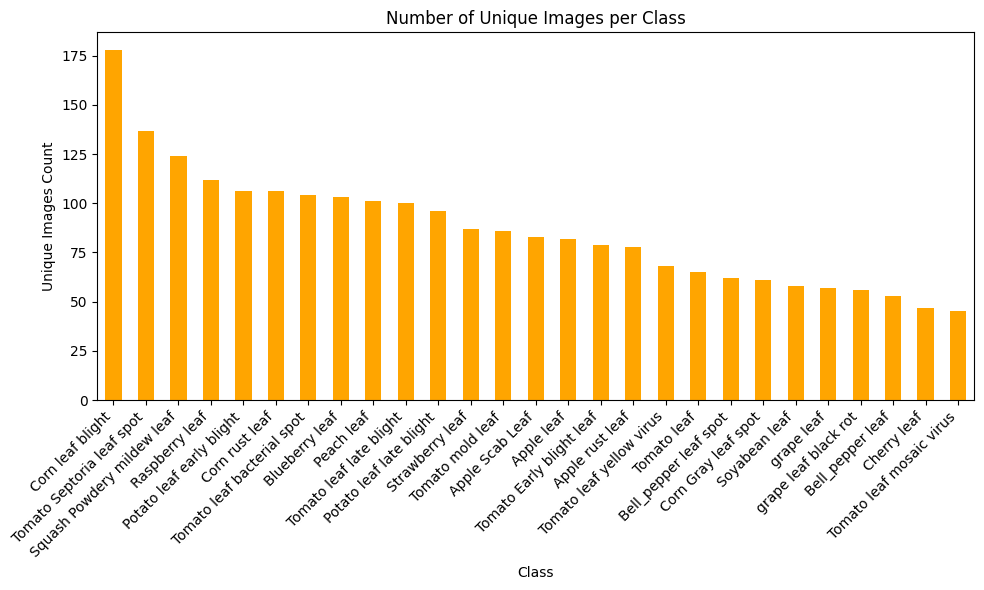

In [ ]:
img_per_class = train_annotation_df.groupby("class")["filename"].nunique()

print(img_per_class)

# Optional: plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
img_per_class.sort_values(ascending=False).plot(kind='bar', color='orange')
plt.title("Number of Unique Images per Class")
plt.xlabel("Class")
plt.ylabel("Unique Images Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Count the total number of annotations (rows)
total_annotations = len(train_annotation_df)
print(f"Total number of annotations in '{cleaned_annotations_path}': {total_annotations}")

Total number of annotations in '/content/train/_annotations_clean.csv': 8340


class
Blueberry leaf                816
Tomato leaf yellow virus      759
Peach leaf                    579
Raspberry leaf                539
Strawberry leaf               443
Tomato Septoria leaf spot     402
Tomato leaf                   373
Corn leaf blight              356
Bell_pepper leaf              312
Potato leaf early blight      301
Tomato mold leaf              279
Tomato leaf bacterial spot    266
Soyabean leaf                 261
Bell_pepper leaf spot         248
Squash Powdery mildew leaf    248
Apple leaf                    237
Potato leaf late blight       235
Tomato leaf mosaic virus      225
Cherry leaf                   220
grape leaf                    205
Tomato leaf late blight       204
Tomato Early blight leaf      193
Apple rust leaf               167
Apple Scab Leaf               158
grape leaf black rot          125
Corn rust leaf                117
Corn Gray leaf spot            72
Name: count, dtype: int64


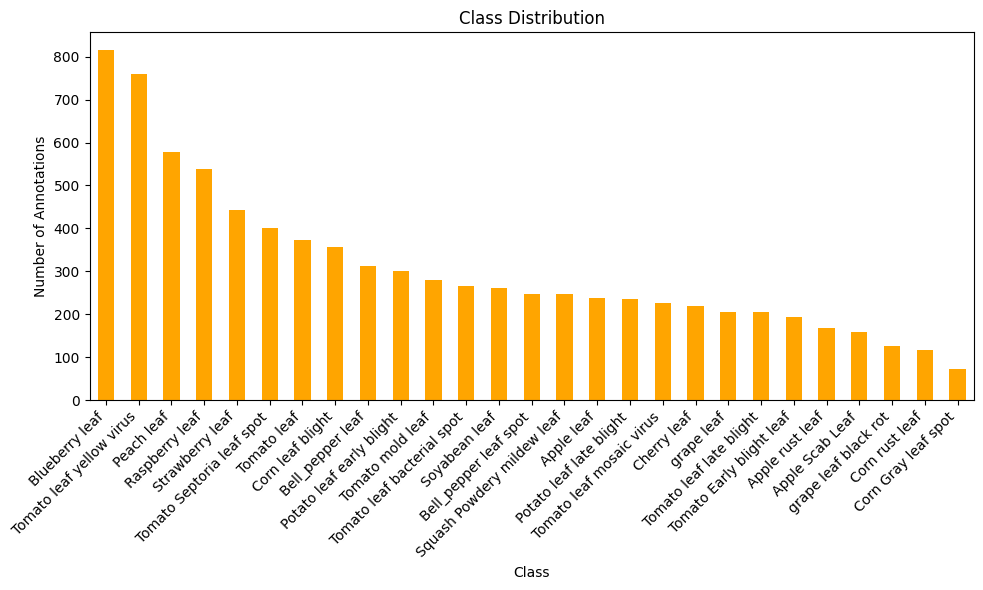

In [ ]:
# Count number of samples per class
class_counts = train_annotation_df['class'].value_counts()

# Display counts
print(class_counts)

# Plot distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar',color='orange')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Annotations")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Displaying the first image from each class:


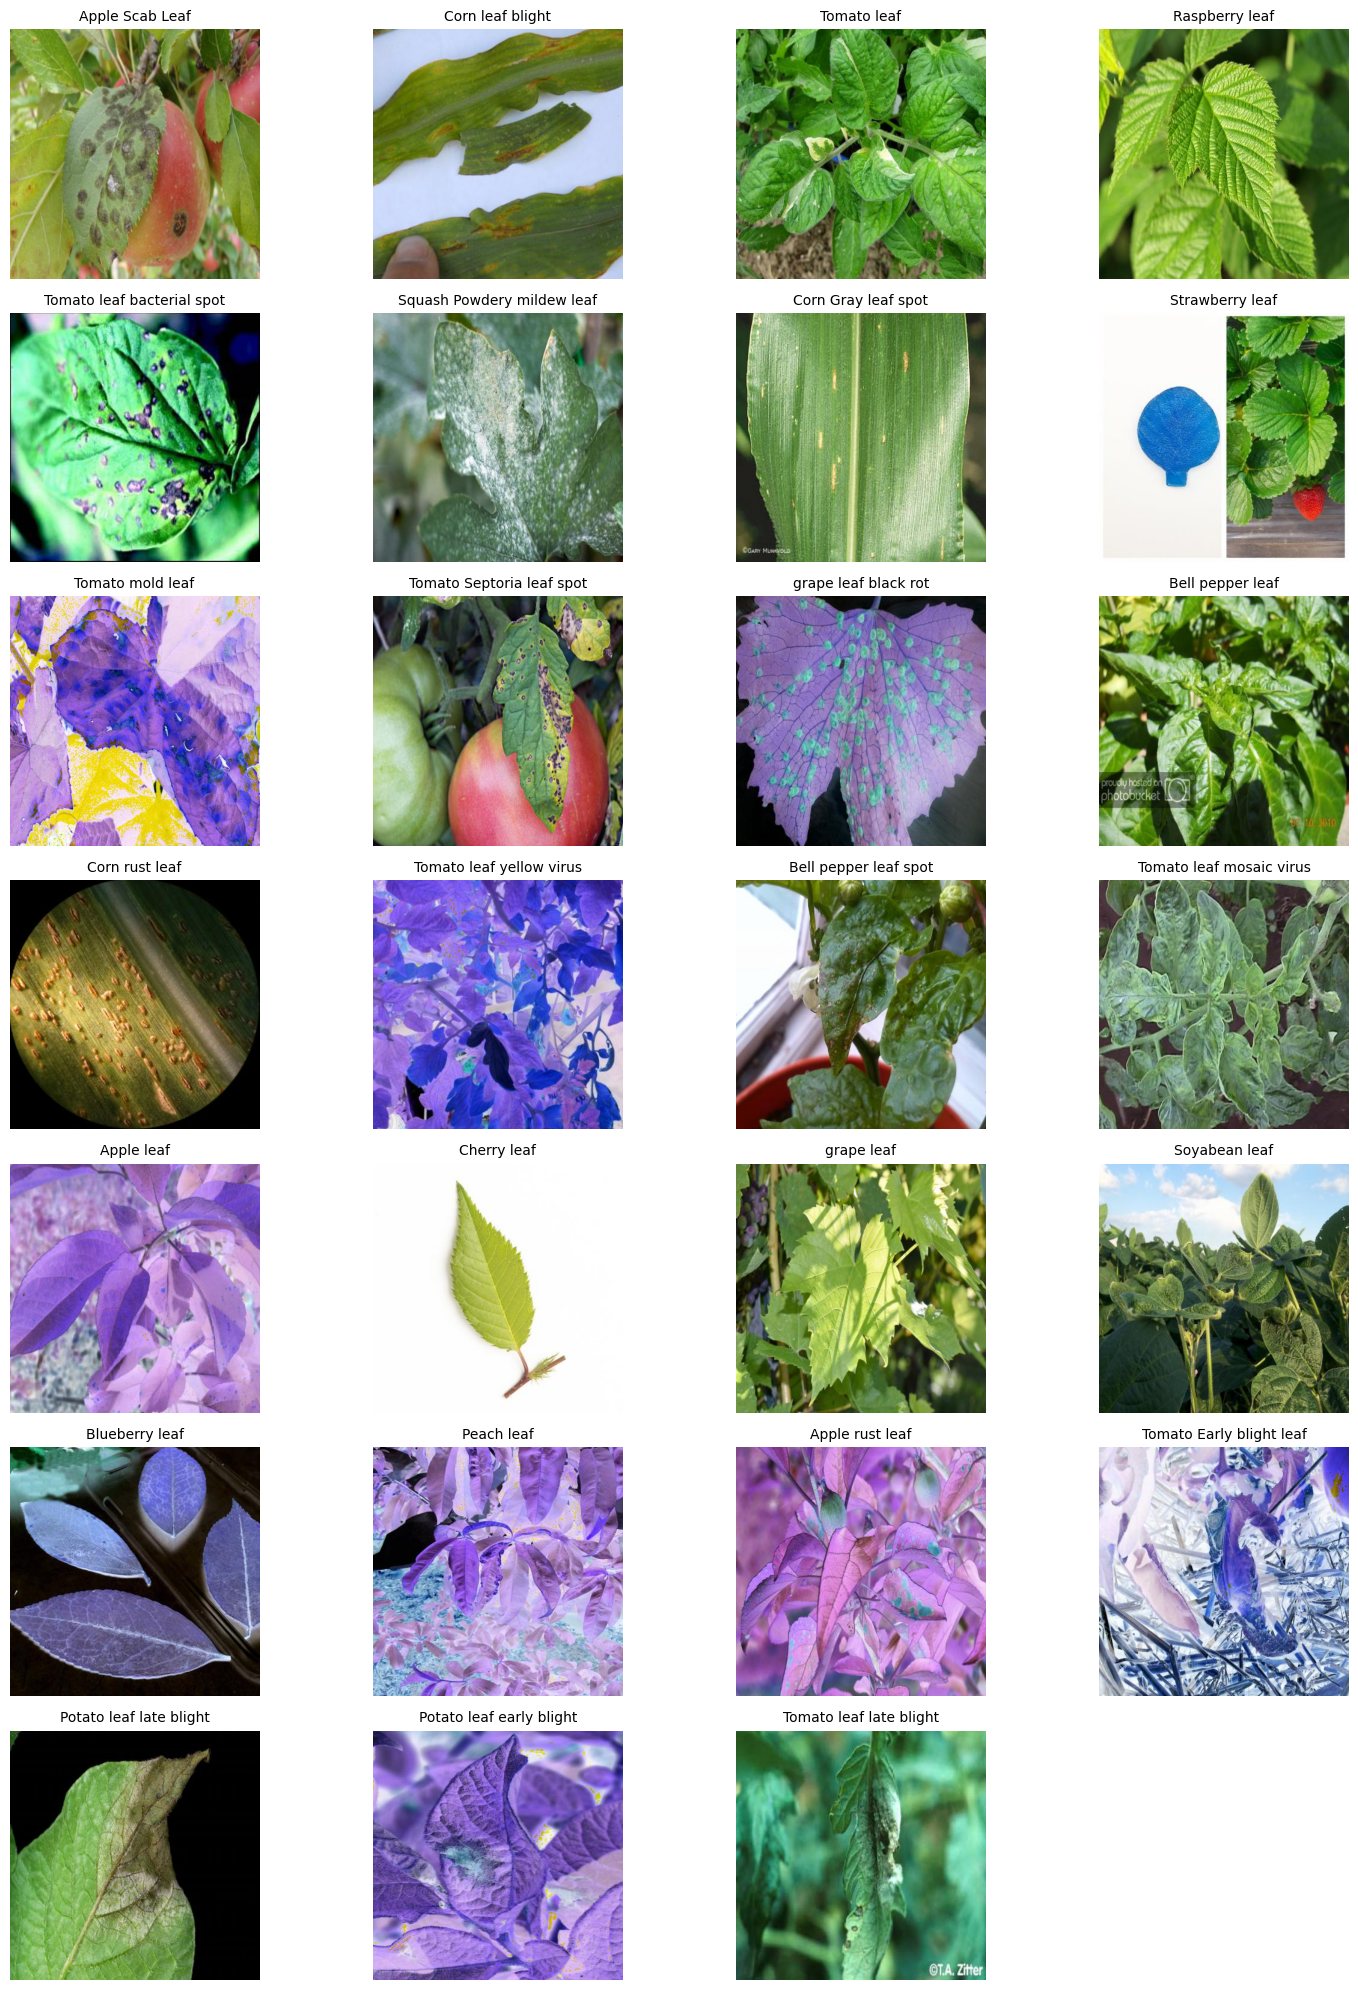

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

base_class_dir = '/content/train/images_by_class'

# Get a list of all class directories
class_dirs = [d for d in os.listdir(base_class_dir) if os.path.isdir(os.path.join(base_class_dir, d))]

print("Displaying the first image from each class:")

plt.figure(figsize=(15, 20)) # Adjust figure size as needed
for i, class_name in enumerate(class_dirs):
    class_dir = os.path.join(base_class_dir, class_name)
    image_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if image_files:
        # Select the first image from the sorted list of files
        first_image_file = sorted(image_files)[0]
        image_path = os.path.join(class_dir, first_image_file)

        try:
            img = mpimg.imread(image_path)

            # Create a subplot for each image
            plt.subplot(len(class_dirs) // 4 + 1, 4, i + 1) # Adjust subplot grid as needed
            plt.imshow(img)
            plt.title(class_name.replace("_", " "), fontsize=10) # Display class name as title
            plt.axis('off') # Hide axes

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
    else:
        print(f"No image files found in {class_dir}. Skipping.")

plt.tight_layout() # Adjust layout to prevent titles overlapping
plt.show()

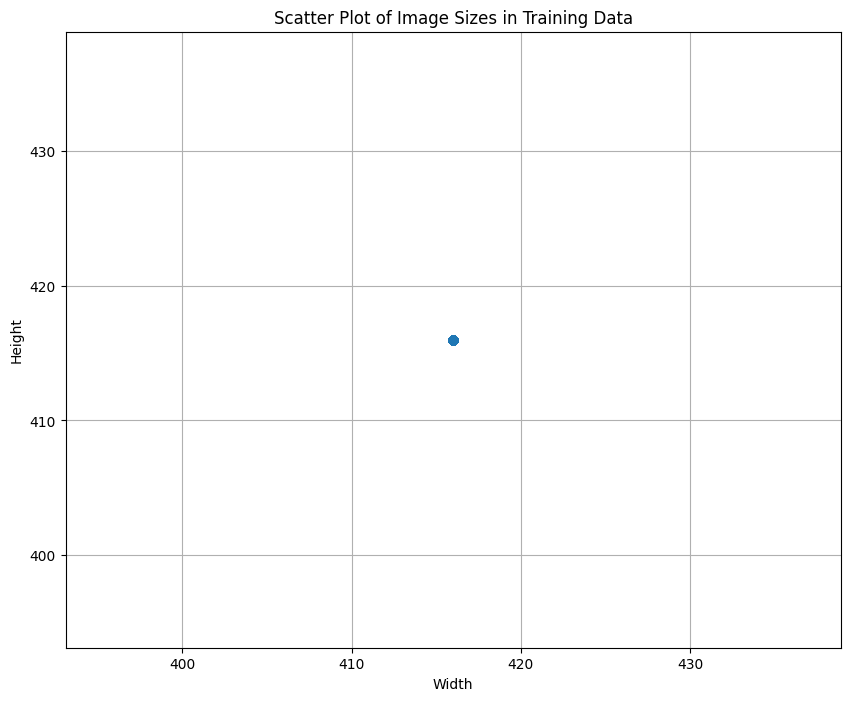

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

image_dir = "/content/train/images"
image_sizes = []

# Iterate through all files in the directory
for filename in os.listdir(image_dir):
    filepath = os.path.join(image_dir, filename)
    if os.path.isfile(filepath):
        try:
            img = Image.open(filepath)
            image_sizes.append(img.size) # size is (width, height)
        except Exception as e:
            print(f"Error processing image {filename}: {e}")

# Extract widths and heights
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(widths, heights, alpha=0.5)
plt.title("Scatter Plot of Image Sizes in Training Data")
plt.xlabel("Width")
plt.ylabel("Height")
plt.grid(True)
plt.show()

**Flatten**

In [ ]:
import os
import cv2
import numpy as np

folder_path = "/content/train/images_by_class/Apple_Scab_Leaf"
class_0_flatten = []

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    # Read the image (all are jpg)
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # use IMREAD_COLOR if needed

    # Flatten the image
    class_0_flatten.append(image.flatten())

# Convert to NumPy array if needed
class_0_flatten = np.array(class_0_flatten)
print(class_0_flatten.shape)


(83, 173056)


In [ ]:
class_0_flatten[0]

array([144, 144, 146, ..., 134, 131, 126], dtype=uint8)

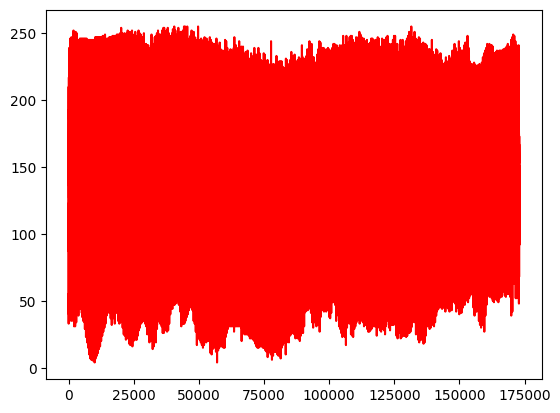

In [ ]:
for i in range(2):
    plt.plot(class_0_flatten[i], color='red')

plt.show();

In [ ]:
class_0_median = np.median(class_0_flatten, axis=0)


In [ ]:
class_0_median[0]

np.float64(127.0)

In [ ]:
class_0_median.shape

(173056,)

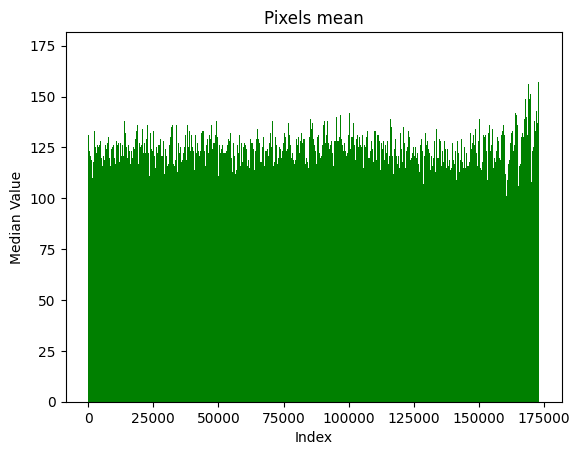

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example assuming class_0_median is already computed
plt.bar(np.arange(len(class_0_median)), class_0_median, color='green', width=1)
plt.xlabel('Index')
plt.ylabel('Median Value')
plt.title('Pixels mean')
plt.show()


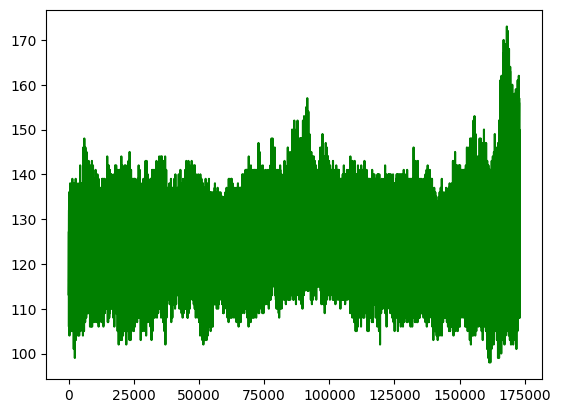

In [ ]:

plt.plot(class_0_median, color='green')
plt.show()

In [ ]:
'''

class_0_flatten = []
class_1_flatten = []
class_2_flatten = []


for image in final_data[final_labels == 0]:
    class_0_flatten.append(image.flatten())

for image in final_data[final_labels == 1]:
    class_1_flatten.append(image.flatten())

for image in final_data[final_labels == 2]:
    class_2_flatten.append(image.flatten())


class_0_flatten = np.array(class_0_flatten, dtype='uint8')
class_1_flatten = np.array(class_1_flatten, dtype='uint8')
class_2_flatten = np.array(class_2_flatten, dtype='uint8')

class_0_flatten.shape, class_1_flatten.shape, class_2_flatten.shape, final_data.shape, final_labels.shape

'''

"\n\nclass_0_flatten = []\nclass_1_flatten = []\nclass_2_flatten = []\n\n\nfor image in final_data[final_labels == 0]:\n    class_0_flatten.append(image.flatten())\n\nfor image in final_data[final_labels == 1]:\n    class_1_flatten.append(image.flatten())\n\nfor image in final_data[final_labels == 2]:\n    class_2_flatten.append(image.flatten())\n\n\nclass_0_flatten = np.array(class_0_flatten, dtype='uint8')\nclass_1_flatten = np.array(class_1_flatten, dtype='uint8')\nclass_2_flatten = np.array(class_2_flatten, dtype='uint8')\n\nclass_0_flatten.shape, class_1_flatten.shape, class_2_flatten.shape, final_data.shape, final_labels.shape\n\n"

In [ ]:
# Cell 1 — Flatten all folders (Grayscale) + print class names
from pathlib import Path
import numpy as np
from PIL import Image

dataset_root = Path("/content/train/images_by_class")   # each folder = one class
classes = sorted([d.name for d in dataset_root.iterdir() if d.is_dir()])

print(f"Number of classes: {len(classes)}")
for i, c in enumerate(classes, 1):
    print(f"{i:2d}) {c}")

pixels_by_class = {}  # class -> 2D array (N_images, 173056)
for cls in classes:
    vecs = []
    for p in (dataset_root/cls).rglob("*.jpg"):
        with Image.open(p) as im:
            arr = np.array(im.convert("L"), dtype=np.float32)  # grayscale
        vecs.append(arr.flatten())  # each image = length 173056
    pixels_by_class[cls] = np.stack(vecs)  # shape (N, 173056)

print("Flattening completed for all folders.")


Number of classes: 27
 1) Apple_Scab_Leaf
 2) Apple_leaf
 3) Apple_rust_leaf
 4) Bell_pepper_leaf
 5) Bell_pepper_leaf_spot
 6) Blueberry_leaf
 7) Cherry_leaf
 8) Corn_Gray_leaf_spot
 9) Corn_leaf_blight
10) Corn_rust_leaf
11) Peach_leaf
12) Potato_leaf_early_blight
13) Potato_leaf_late_blight
14) Raspberry_leaf
15) Soyabean_leaf
16) Squash_Powdery_mildew_leaf
17) Strawberry_leaf
18) Tomato_Early_blight_leaf
19) Tomato_Septoria_leaf_spot
20) Tomato_leaf
21) Tomato_leaf_bacterial_spot
22) Tomato_leaf_late_blight
23) Tomato_leaf_mosaic_virus
24) Tomato_leaf_yellow_virus
25) Tomato_mold_leaf
26) grape_leaf
27) grape_leaf_black_rot
Flattening completed for all folders.


In [ ]:
# Cell 2 — Compute per-pixel statistics (mean, median, std) for each class
stats_by_class = {}  # class -> dict of curves
for cls, arr in pixels_by_class.items():
    mean_curve   = arr.mean(axis=0)
    median_curve = np.median(arr, axis=0)
    std_curve    = arr.std(axis=0)
    stats_by_class[cls] = {
        "mean": mean_curve,
        "median": median_curve,
        "std": std_curve
    }

print("Per-pixel statistics computed for", len(stats_by_class), "classes.")


Per-pixel statistics computed for 27 classes.


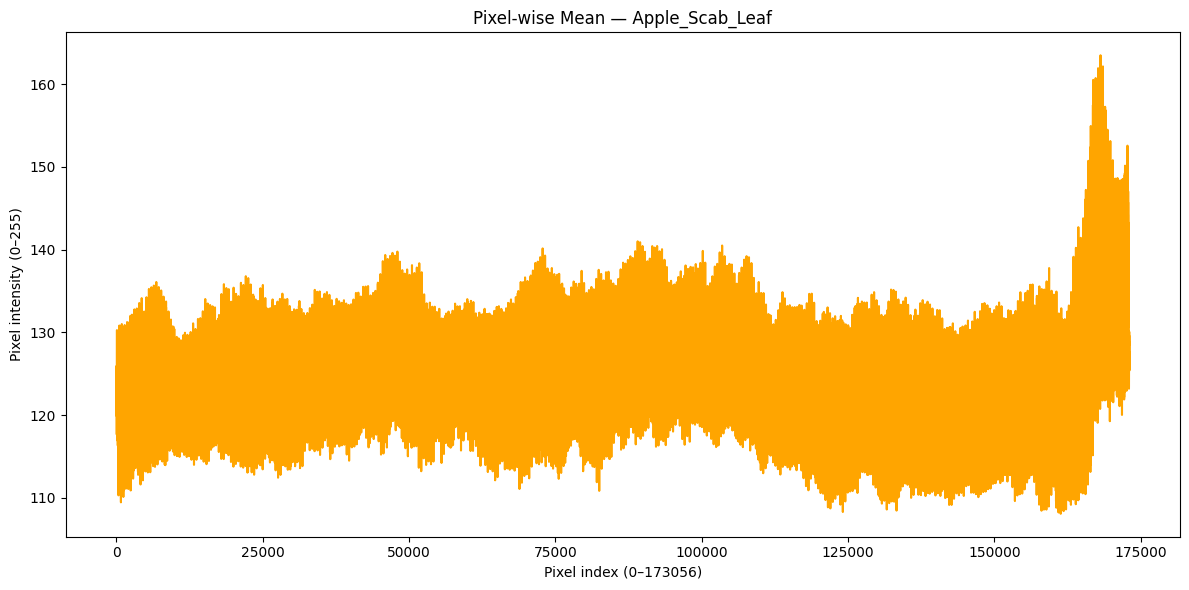

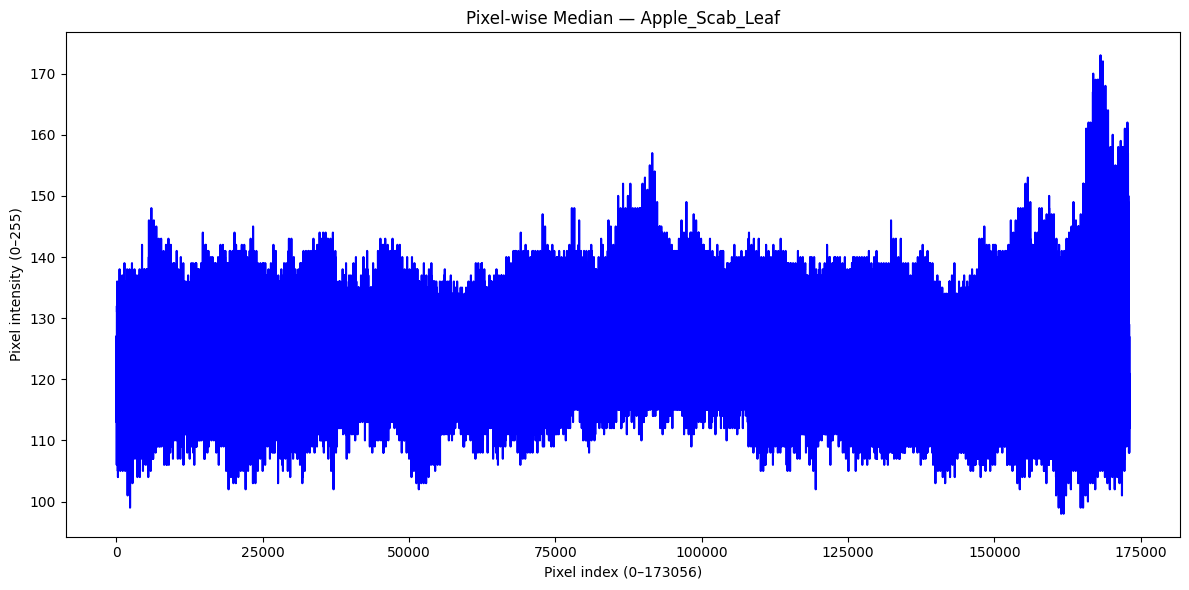

In [ ]:
# Cell 3 — Pixel-wise Mean & Median for one class (separate plots)
import matplotlib.pyplot as plt

target_class = "Apple_Scab_Leaf"  # change to your class
arr = pixels_by_class[target_class]   # shape (N, 173056)

mean_curve   = arr.mean(axis=0)
median_curve = np.median(arr, axis=0)

x = range(arr.shape[1])  # 0 .. 173056

# --- Plot Mean ---
plt.figure(figsize=(12,6))
plt.plot(x, mean_curve, color="orange")
plt.title(f"Pixel-wise Mean — {target_class}")
plt.xlabel("Pixel index (0–173056)")
plt.ylabel("Pixel intensity (0–255)")
plt.tight_layout()
plt.show()

# --- Plot Median ---
plt.figure(figsize=(12,6))
plt.plot(x, median_curve, color="blue")
plt.title(f"Pixel-wise Median — {target_class}")
plt.xlabel("Pixel index (0–173056)")
plt.ylabel("Pixel intensity (0–255)")
plt.tight_layout()
plt.show()


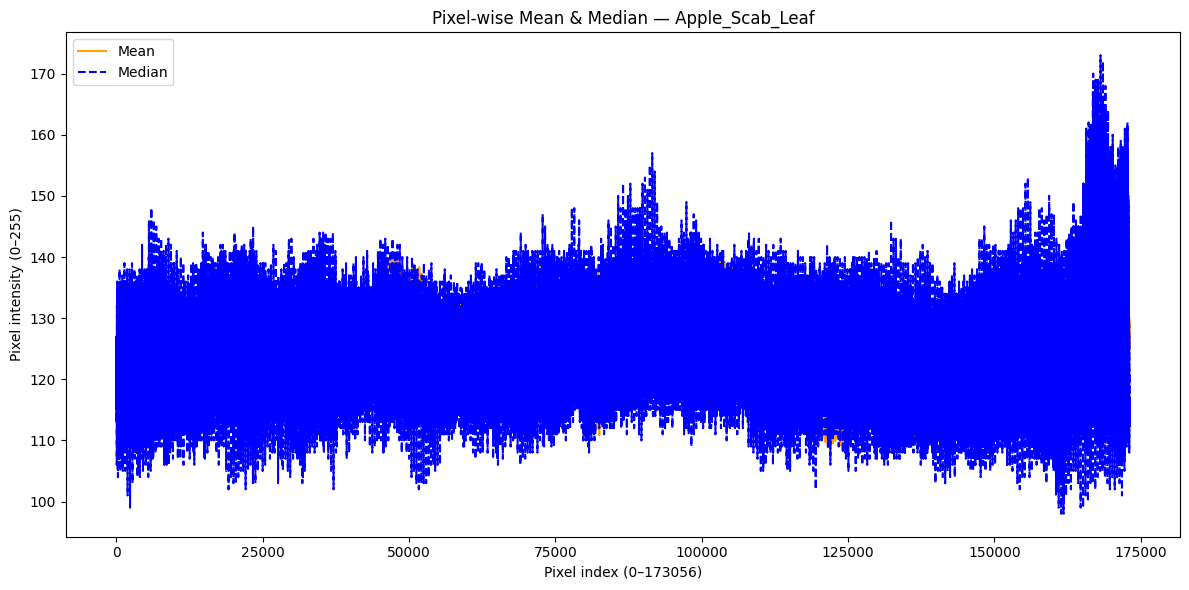

In [ ]:
# Cell 3 — Pixel-wise mean & median for one class
import matplotlib.pyplot as plt

target_class = "Apple_Scab_Leaf"  # change to the class you want
arr = pixels_by_class[target_class]   # shape (N, 173056)

mean_curve   = arr.mean(axis=0)
median_curve = np.median(arr, axis=0)

x = range(arr.shape[1])  # 0 .. 173056

plt.figure(figsize=(12,6))
plt.plot(x, mean_curve,   label="Mean",   color="orange")
plt.plot(x, median_curve, label="Median", color="blue", linestyle="--")

plt.title(f"Pixel-wise Mean & Median — {target_class}")
plt.xlabel("Pixel index (0–173056)")
plt.ylabel("Pixel intensity (0–255)")
plt.legend()
plt.tight_layout()
plt.show()


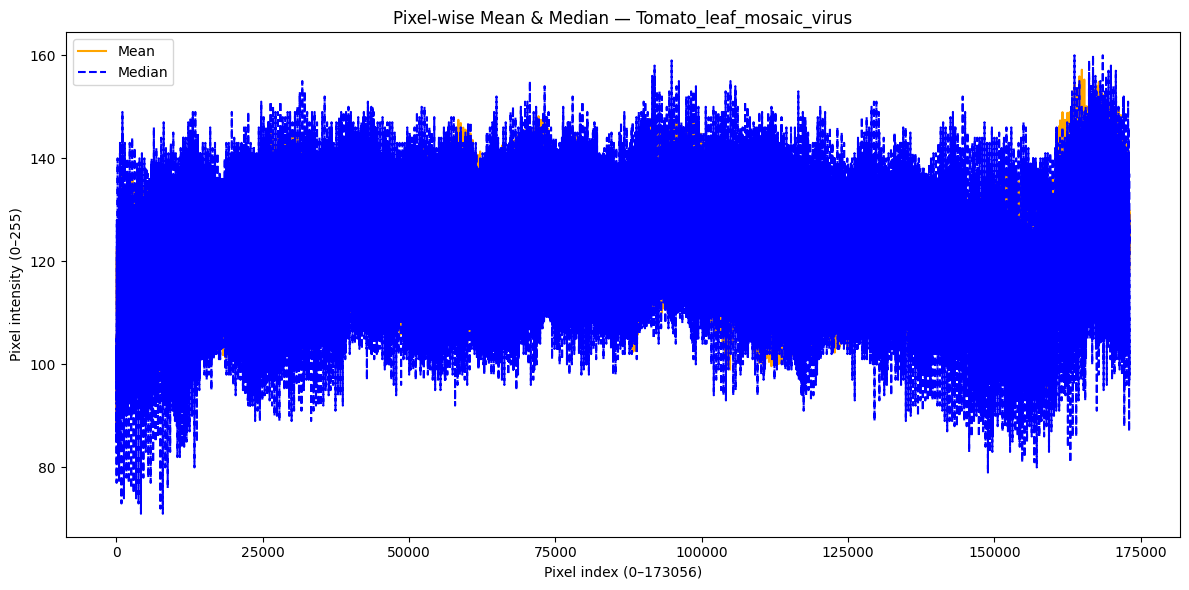

In [ ]:
# Cell 3 — Pixel-wise mean & median for one class
import matplotlib.pyplot as plt

target_class = "Tomato_leaf_mosaic_virus"  # change to the class you want
arr = pixels_by_class[target_class]   # shape (N, 173056)

mean_curve   = arr.mean(axis=0)
median_curve = np.median(arr, axis=0)

x = range(arr.shape[1])  # 0 .. 173056

plt.figure(figsize=(12,6))
plt.plot(x, mean_curve,   label="Mean",   color="orange")
plt.plot(x, median_curve, label="Median", color="blue", linestyle="--")

plt.title(f"Pixel-wise Mean & Median — {target_class}")
plt.xlabel("Pixel index (0–173056)")
plt.ylabel("Pixel intensity (0–255)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Cell 1 — Flatten all folders (Grayscale) + print class names
from pathlib import Path
import numpy as np
from PIL import Image

dataset_root = Path("/content/train/images_by_class")   # each folder = one class
classes = sorted([d.name for d in dataset_root.iterdir() if d.is_dir()])

print(f"Number of classes: {len(classes)}")
for i, c in enumerate(classes, 1):
    print(f"{i:2d}) {c}")

pixels_by_class = {}
for cls in classes:
    vecs = []
    for p in (dataset_root/cls).rglob("*.jpg"):
        with Image.open(p) as im:
            arr = np.array(im.convert("L"), dtype=np.float32)  # convert to grayscale
        vecs.append(arr.flatten())
    pixels_by_class[cls] = np.concatenate(vecs)
print("Flattening all folders completed.")

Number of classes: 27
 1) Apple_Scab_Leaf
 2) Apple_leaf
 3) Apple_rust_leaf
 4) Bell_pepper_leaf
 5) Bell_pepper_leaf_spot
 6) Blueberry_leaf
 7) Cherry_leaf
 8) Corn_Gray_leaf_spot
 9) Corn_leaf_blight
10) Corn_rust_leaf
11) Peach_leaf
12) Potato_leaf_early_blight
13) Potato_leaf_late_blight
14) Raspberry_leaf
15) Soyabean_leaf
16) Squash_Powdery_mildew_leaf
17) Strawberry_leaf
18) Tomato_Early_blight_leaf
19) Tomato_Septoria_leaf_spot
20) Tomato_leaf
21) Tomato_leaf_bacterial_spot
22) Tomato_leaf_late_blight
23) Tomato_leaf_mosaic_virus
24) Tomato_leaf_yellow_virus
25) Tomato_mold_leaf
26) grape_leaf
27) grape_leaf_black_rot
Flattening all folders completed.


NameError: name 'shape' is not defined

In [ ]:
# Cell 2 — Compute statistics for all folders (without plotting)
stats_by_class = {}  # class -> (mean, median, std)
for cls, v in pixels_by_class.items():
    m  = float(v.mean())
    md = float(np.median(v))
    sd = float(v.std(ddof=0))
    stats_by_class[cls] = (m, md, sd)

print("Statistics computed for", len(stats_by_class), "classes.")


Statistics computed for 27 classes.


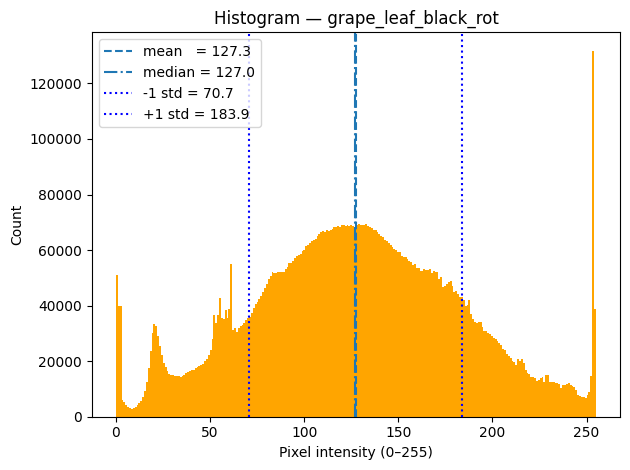

In [ ]:
# Cell 3 — Plot for a single class (Histogram + mean/median/±std)
import matplotlib.pyplot as plt

target_class = "grape_leaf_black_rot"  # ← name of the folder you want
v = pixels_by_class[target_class]
m, md, sd = stats_by_class[target_class]

plt.figure()
plt.hist(v, bins=256, range=(0,255), color='orange')
plt.axvline(m,  linestyle="--", label=f"mean   = {m:.1f}")
plt.axvline(md, linestyle="-.", label=f"median = {md:.1f}")
plt.axvline(m - sd, linestyle=":", color="blue", label=f"-1 std = {m-sd:.1f}")
plt.axvline(m + sd, linestyle=":", color="blue", label=f"+1 std = {m+sd:.1f}")

plt.title(f"Histogram — {target_class}")
plt.xlabel("Pixel intensity (0–255)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


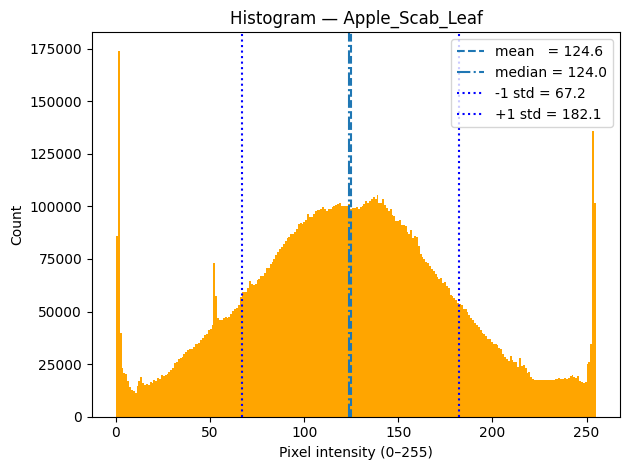

In [ ]:
# Cell 3 — Plot for a single class (Histogram + mean/median/±std)
import matplotlib.pyplot as plt

target_class = "Apple_Scab_Leaf"  # ← name of the folder you want
v = pixels_by_class[target_class]
m, md, sd = stats_by_class[target_class]

plt.figure()
plt.hist(v, bins=256, range=(0,255), color='orange')
plt.axvline(m,  linestyle="--", label=f"mean   = {m:.1f}")
plt.axvline(md, linestyle="-.", label=f"median = {md:.1f}")
plt.axvline(m - sd, linestyle=":", color="blue", label=f"-1 std = {m-sd:.1f}")
plt.axvline(m + sd, linestyle=":", color="blue", label=f"+1 std = {m+sd:.1f}")

plt.title(f"Histogram — {target_class}")
plt.xlabel("Pixel intensity (0–255)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


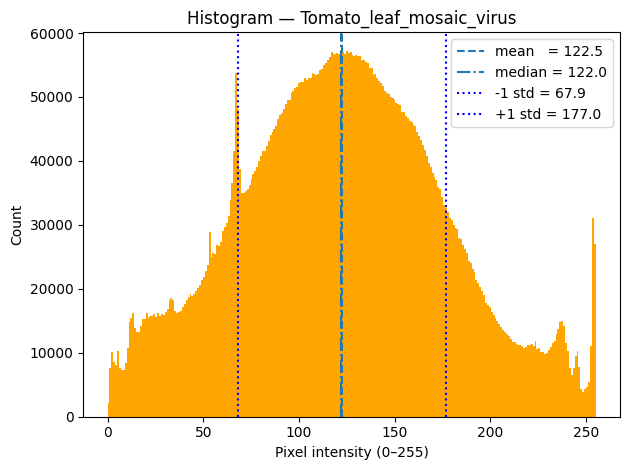

In [ ]:
# Cell 3 — Plot for a single class (Histogram + mean/median/±std)
import matplotlib.pyplot as plt

target_class = "Tomato_leaf_mosaic_virus"  # ← name of the folder you want
v = pixels_by_class[target_class]
m, md, sd = stats_by_class[target_class]

plt.figure()
plt.hist(v, bins=256, range=(0,255), color='orange')
plt.axvline(m,  linestyle="--", label=f"mean   = {m:.1f}")
plt.axvline(md, linestyle="-.", label=f"median = {md:.1f}")
plt.axvline(m - sd, linestyle=":", color="blue", label=f"-1 std = {m-sd:.1f}")
plt.axvline(m + sd, linestyle=":", color="blue", label=f"+1 std = {m+sd:.1f}")

plt.title(f"Histogram — {target_class}")
plt.xlabel("Pixel intensity (0–255)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


# **Data Preprocessing**

**Spliting train and validation data for 0.1 percentage**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path

df = train_annotation_df

# One row per image: pick a representative class per image (most frequent class)
per_image = (
    df.groupby('filename')['class']
      .agg(lambda s: s.mode().iat[0])  # if multiple modes, take the first
      .reset_index()
)

# Split image names into train/val (shuffles by default; set random_state for reproducibility)
train_names, val_names = train_test_split(
    per_image['filename'],
    test_size=0.1,         # 20% goes to validation
    shuffle=True,          # default is True; included here for clarity
    random_state=42,       # make the split repeatable
    stratify=per_image['class']  # keep class distribution balanced
)

# Filter the original CSV rows by image names → full per-image annotations
train_df = df[df['filename'].isin(train_names)]
val_df   = df[df['filename'].isin(val_names)]


SAVE_train = Path(train_images_old)
SAVE_train.mkdir(parents=True, exist_ok=True)

SAVE_val = Path(val_images_old)
SAVE_val.mkdir(parents=True, exist_ok=True)



# Save split CSVs
train_df.to_csv(SAVE_train / "train_annotations.csv", index=False)
val_df.to_csv(SAVE_val / "val_annotations.csv", index=False)

print(f"Saved {len(train_df)} rows to {SAVE_train / 'train_annotations.csv'}")
print(f"Saved {len(val_df)} rows to {SAVE_val / 'val_annotations.csv'}")

Saved 7418 rows to /content/train/train_annotations.csv
Saved 922 rows to /content/val/val_annotations.csv


**Moving splitted images to validation folder**

In [ ]:
import os
import shutil

# Define the base directory for the training images
base_dir = train_images_new

# Define the directory for the validation images
val_dir = val_images_new
os.makedirs(val_dir, exist_ok=True)

# Move validation images to the validation directory
moved_count = 0
for filename in val_df['filename'].unique():
    src_path = os.path.join(base_dir, filename)
    dest_path = os.path.join(val_dir, filename)
    if os.path.exists(src_path):
        shutil.move(src_path, dest_path)
        moved_count += 1
    else:
        print(f"Warning: File not found in training directory: {src_path}")

print(f"\nAttempted to move {len(val_df['filename'].unique())} unique validation images. Successfully moved {moved_count} images to {val_dir}.")


Attempted to move 232 unique validation images. Successfully moved 232 images to /content/val/images.


**Making function for converting CSV files to TXT files for YOLO**

In [ ]:
import pandas as pd
from pathlib import Path
from urllib.parse import unquote
import re

def convert_csv_to_yolo(CSV_PATH, OUT_DIR):
  # -------- Paths (edit these) --------
  CSV_PATH = CSV_PATH           # your CSV file
  OUT_DIR  = OUT_DIR # output folder for YOLO label .txt files

  # -------- Exact class order (IDs 0..26) --------
  CLASSES = [
      'Apple Scab Leaf','Apple leaf','Apple rust leaf','Bell_pepper leaf','Bell_pepper leaf spot',
      'Blueberry leaf','Cherry leaf','Corn Gray leaf spot','Corn leaf blight','Corn rust leaf',
      'Peach leaf','Potato leaf early blight','Potato leaf late blight','Raspberry leaf','Soyabean leaf',
      'Squash Powdery mildew leaf','Strawberry leaf','Tomato Early blight leaf','Tomato Septoria leaf spot',
      'Tomato leaf','Tomato leaf bacterial spot','Tomato leaf late blight','Tomato leaf mosaic virus',
      'Tomato leaf yellow virus','Tomato mold leaf','grape leaf','grape leaf black rot'
  ]
  assert len(CLASSES) == 27, "CLASSES must contain exactly 27 names."

  # Normalize class names for robust matching (spaces/underscores/case-insensitive)
  def norm(s: str) -> str:
      s = unquote(str(s)).strip()
      s = s.replace("_", " ")
      s = re.sub(r"\s+", " ", s)
      return s.lower()

  name2id = {norm(name): i for i, name in enumerate(CLASSES)}

  # -------- Read CSV --------
  df = pd.read_csv(CSV_PATH)
  df.columns = [str(c).strip().lower() for c in df.columns]

  required = ["filename","width","height","class","xmin","ymin","xmax","ymax"]
  missing = [c for c in required if c not in df.columns]
  if missing:
      raise ValueError(f"Missing required CSV columns: {missing}")

  # Keep only the filename (drop folders) and build the stem (basename without extension)
  df["__file"] = df["filename"].map(lambda x: Path(unquote(str(x))).name)
  df["__stem"] = df["__file"].map(lambda x: Path(x).stem)

  # Ensure every class in CSV exists in your CLASSES list
  unknown = sorted(set(norm(x) for x in df["class"]) - set(name2id.keys()))
  if unknown:
      raise ValueError(
          "Some CSV classes are not in your CLASSES list (so IDs cannot match your order):\n"
          + "\n".join(unknown)
      )

  # Convert one row to a YOLO line: "<class_id> <cx> <cy> <w> <h>" (all normalized to [0,1])
  def row_to_line(r):
      W, H = float(r["width"]), float(r["height"])
      xmin, ymin, xmax, ymax = float(r["xmin"]), float(r["ymin"]), float(r["xmax"]), float(r["ymax"])

      # Standard YOLO conversion from XYXY (top-left / bottom-right in pixels)
      cx = ((xmin + xmax) / 2.0) / W
      cy = ((ymin + ymax) / 2.0) / H
      w  = (xmax - xmin) / W
      h  = (ymax - ymin) / H

      # Clamp to [0,1] just in case
      clip = lambda v: max(0.0, min(1.0, float(v)))
      cx, cy, w, h = map(clip, (cx, cy, w, h))

      cls_id = name2id[norm(r["class"])]
      return f"{cls_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}"

  # -------- Write one .txt per image (same basename) --------
  out = Path(OUT_DIR)
  out.mkdir(parents=True, exist_ok=True)

  files_written = 0
  boxes_total = 0
  for stem, g in df.groupby("__stem"):
      lines = [row_to_line(r) for _, r in g.iterrows()]
      (out / f"{stem}.txt").write_text("\n".join(lines), encoding="utf-8")
      files_written += 1
      boxes_total += len(lines)

  '''# Optional: save the classes list (ID order) for reference
  (out / "classes.txt").write_text("\n".join(CLASSES), encoding="utf-8")'''

  print(f"✅ Done: wrote {files_written} label files with {boxes_total} boxes into: {out}")
  print("Class ID mapping (id → name):")
  for i, name in enumerate(CLASSES):
      print(f"{i:2d}: {name}")


**Converting train csv to txt**

In [ ]:
convert_csv_to_yolo(train_splitted_csv, train_yolo_labels)

✅ Done: wrote 2086 label files with 7418 boxes into: /content/train/labels
Class ID mapping (id → name):
 0: Apple Scab Leaf
 1: Apple leaf
 2: Apple rust leaf
 3: Bell_pepper leaf
 4: Bell_pepper leaf spot
 5: Blueberry leaf
 6: Cherry leaf
 7: Corn Gray leaf spot
 8: Corn leaf blight
 9: Corn rust leaf
10: Peach leaf
11: Potato leaf early blight
12: Potato leaf late blight
13: Raspberry leaf
14: Soyabean leaf
15: Squash Powdery mildew leaf
16: Strawberry leaf
17: Tomato Early blight leaf
18: Tomato Septoria leaf spot
19: Tomato leaf
20: Tomato leaf bacterial spot
21: Tomato leaf late blight
22: Tomato leaf mosaic virus
23: Tomato leaf yellow virus
24: Tomato mold leaf
25: grape leaf
26: grape leaf black rot


**Converting Validation csv to txt**

In [ ]:
convert_csv_to_yolo(val_annotation_clean, val_yolo_labels)

✅ Done: wrote 232 label files with 922 boxes into: /content/val/labels
Class ID mapping (id → name):
 0: Apple Scab Leaf
 1: Apple leaf
 2: Apple rust leaf
 3: Bell_pepper leaf
 4: Bell_pepper leaf spot
 5: Blueberry leaf
 6: Cherry leaf
 7: Corn Gray leaf spot
 8: Corn leaf blight
 9: Corn rust leaf
10: Peach leaf
11: Potato leaf early blight
12: Potato leaf late blight
13: Raspberry leaf
14: Soyabean leaf
15: Squash Powdery mildew leaf
16: Strawberry leaf
17: Tomato Early blight leaf
18: Tomato Septoria leaf spot
19: Tomato leaf
20: Tomato leaf bacterial spot
21: Tomato leaf late blight
22: Tomato leaf mosaic virus
23: Tomato leaf yellow virus
24: Tomato mold leaf
25: grape leaf
26: grape leaf black rot


**Converting test csv to txt**

In [ ]:
convert_csv_to_yolo(test_annotation_clean, test_yolo_labels)

✅ Done: wrote 238 label files with 454 boxes into: /content/test/labels
Class ID mapping (id → name):
 0: Apple Scab Leaf
 1: Apple leaf
 2: Apple rust leaf
 3: Bell_pepper leaf
 4: Bell_pepper leaf spot
 5: Blueberry leaf
 6: Cherry leaf
 7: Corn Gray leaf spot
 8: Corn leaf blight
 9: Corn rust leaf
10: Peach leaf
11: Potato leaf early blight
12: Potato leaf late blight
13: Raspberry leaf
14: Soyabean leaf
15: Squash Powdery mildew leaf
16: Strawberry leaf
17: Tomato Early blight leaf
18: Tomato Septoria leaf spot
19: Tomato leaf
20: Tomato leaf bacterial spot
21: Tomato leaf late blight
22: Tomato leaf mosaic virus
23: Tomato leaf yellow virus
24: Tomato mold leaf
25: grape leaf
26: grape leaf black rot


**Making data.yaml for YOLO**

In [ ]:
import yaml

# Define the paths to your training and validation data
train_img_dir = train_images_new
#train_label_dir = '/content/train/labels'
val_img_dir = val_images_new
#val_label_dir = '/content/validation/labels'
test_img_dir = test_images_new
#test_label_dir = '/content/test/labels'


# Define the class names in the order they appear in your labels
classes = [
    'Apple Scab Leaf','Apple leaf','Apple rust leaf','Bell_pepper leaf','Bell_pepper leaf spot',
    'Blueberry leaf','Cherry leaf','Corn Gray leaf spot','Corn leaf blight','Corn rust leaf',
    'Peach leaf','Potato leaf early blight','Potato leaf late blight','Raspberry leaf','Soyabean leaf',
    'Squash Powdery mildew leaf','Strawberry leaf','Tomato Early blight leaf','Tomato Septoria leaf spot',
    'Tomato leaf','Tomato leaf bacterial spot','Tomato leaf late blight','Tomato leaf mosaic virus',
    'Tomato leaf yellow virus','Tomato mold leaf','grape leaf','grape leaf black rot'
]



# Create the data dictionary
data = {
    'train': train_img_dir,
    'val': val_img_dir,
    'test': test_img_dir,
    'nc': len(classes),
    'names': classes,
}

# Define the path to save the data.yaml file
data_yaml_path = yaml_path

# Write the data dictionary to the data.yaml file
with open(data_yaml_path, 'w') as f:
    yaml.dump(data, f)

print(f"data.yaml file created at: {data_yaml_path}")

data.yaml file created at: /content/data.yaml


In [ ]:
train_annotation_df = pd.read_csv(train_splitted_csv)

class
Apple Scab Leaf                75
Apple leaf                     74
Apple rust leaf                70
Bell_pepper leaf               48
Bell_pepper leaf spot          56
Blueberry leaf                 93
Cherry leaf                    42
Corn Gray leaf spot            55
Corn leaf blight              160
Corn rust leaf                 95
Peach leaf                     91
Potato leaf early blight       95
Potato leaf late blight        87
Raspberry leaf                101
Soyabean leaf                  52
Squash Powdery mildew leaf    112
Strawberry leaf                78
Tomato Early blight leaf       71
Tomato Septoria leaf spot     123
Tomato leaf                    58
Tomato leaf bacterial spot     94
Tomato leaf late blight        90
Tomato leaf mosaic virus       41
Tomato leaf yellow virus       61
Tomato mold leaf               77
grape leaf                     51
grape leaf black rot           50
Name: filename, dtype: int64


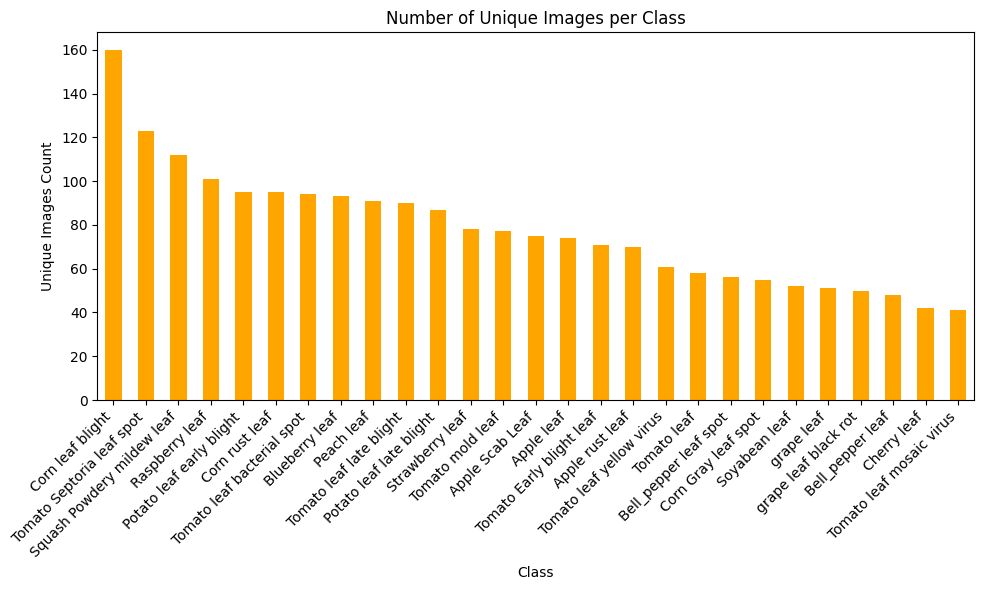

In [ ]:

img_per_class = train_annotation_df.groupby("class")["filename"].nunique()

print(img_per_class)

# Optional: plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
img_per_class.sort_values(ascending=False).plot(kind='bar', color='orange')
plt.title("Number of Unique Images per Class")
plt.xlabel("Class")
plt.ylabel("Unique Images Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Check some criteria before augmentation**

In [ ]:
from pathlib import Path
import glob
from collections import defaultdict

IMGS_TRAIN = Path(train_images_new)
LABS_TRAIN = Path(train_yolo_labels)

def read_yolo_txt(p):
    p = Path(p)
    boxes, labels = [], []
    if p.is_file():
        for ln in p.read_text().strip().splitlines():
            if not ln.strip(): continue
            c, cx, cy, w, h = ln.split()
            labels.append(int(c))
            boxes.append([float(cx), float(cy), float(w), float(h)])
    return boxes, labels

def image_classes(img_path):
    from pathlib import Path
    lp = LABS_TRAIN / (Path(img_path).stem + ".txt")
    _, labels = read_yolo_txt(lp)
    return set(labels)

# per-class counts (train فقط)
all_imgs = sum([glob.glob(str(IMGS_TRAIN/"**/*.jpg"), recursive=True),
                glob.glob(str(IMGS_TRAIN/"**/*.jpeg"), recursive=True),
                glob.glob(str(IMGS_TRAIN/"**/*.png"), recursive=True)], [])
cls2imgs = defaultdict(list)
for p in all_imgs:
    for c in image_classes(p):
        cls2imgs[c].append(p)

cls_counts = {c: len(v) for c,v in cls2imgs.items()}
target = max(cls_counts.values()) if cls_counts else 0
print("max(train):", target)
print("sample:", dict(list(sorted(cls_counts.items())[:10])))


max(train): 160
sample: {0: 75, 1: 74, 2: 70, 3: 48, 4: 56, 5: 93, 6: 42, 7: 55, 8: 160, 9: 95}


In [ ]:
from pathlib import Path; from collections import Counter
exts = Counter(p.suffix for p in Path(train_images_new).rglob("*") if p.is_file())
print(exts)  # look for '.JPG', '.PNG'


Counter({'.jpg': 2086})


In [ ]:
# YOLO train set audit: images ↔ labels
from pathlib import Path
from collections import defaultdict, Counter
import re, sys

# --------------------- CONFIG ---------------------
IMGS = Path(train_images_new)
LABS = Path(train_yolo_labels)

# Set to True to actually apply the fixes (rename/move).
# Default False = only print/report & generate a shell script of proposed fixes.
APPLY_CHANGES = False

# Write a shell script with the proposed operations
WRITE_SHELL_SCRIPT = True
SHELL_SCRIPT_PATH = "proposed_fixes.sh"

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
# --------------------------------------------------

def norm_simple(s: str) -> str:
    """lowercase and remove all non-alnum (for fuzzy matching)"""
    return re.sub(r'[^a-z0-9]+', '', s.lower())

def list_images(root: Path):
    return [p for p in root.rglob("*") if p.is_file() and p.suffix.lower() in IMG_EXTS]

def list_labels(root: Path):
    return [p for p in root.rglob("*.txt") if p.is_file()]

def expected_label_path(img_path: Path) -> Path:
    rel = img_path.relative_to(IMGS).with_suffix(".txt")
    return LABS / rel

def print_header(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

def main():
    imgs = list_images(IMGS)
    labs = list_labels(LABS)

    if not imgs:
        print("No images found. Check IMGS path.")
        return
    print_header("SUMMARY")
    print(f"Images found: {len(imgs)}")
    print(f"Labels found: {len(labs)}")

    # Index labels by:
    #  1) exact relative path (for mirror check)
    #  2) stem -> paths
    #  3) fuzzy norm(stem) -> paths
    labs_by_rel = {p.relative_to(LABS): p for p in labs}
    labs_by_stem = defaultdict(list)
    labs_by_norm = defaultdict(list)
    for lp in labs:
        stem = lp.stem
        labs_by_stem[stem].append(lp)
        labs_by_norm[norm_simple(stem)].append(lp)

    # Track stats & proposed fixes
    missing = []                # (img, expected)
    wrong_dir = []              # (img, found_label, expected_label)
    jpg_txt = []                # labels ending with image-ext+txt
    case_only = []              # (img, found_label, expected_label)
    orphans = []                # labels w/ no corresponding image
    suggestions = []            # (reason, command)

    # Precompute image stems for matching
    imgs_info = []
    imgs_by_stem = defaultdict(list)
    imgs_by_norm = defaultdict(list)
    for ip in imgs:
        rel = ip.relative_to(IMGS)
        stem = ip.stem
        imgs_info.append((ip, rel, stem))
        imgs_by_stem[stem].append(ip)
        imgs_by_norm[norm_simple(stem)].append(ip)

    # 1) Scan labels for obvious naming issues like image.jpg.txt
    IMG_EXT_REGEX = re.compile(r'\.(jpg|jpeg|png|bmp|tif|tiff)$', re.IGNORECASE)
    for lp in labs:
        if IMG_EXT_REGEX.search(lp.stem):
            jpg_txt.append(lp)
            # propose rename: strip trailing image extension from stem
            new_name = Path(lp.stem).name
            new_name = IMG_EXT_REGEX.sub('', new_name) + ".txt"
            target = lp.with_name(new_name)
            suggestions.append(("strip .jpg from label name",
                                f'mv "{lp}" "{target}"'))

    # 2) For each image, check label existence at expected mirrored path
    for ip, rel, stem in imgs_info:
        exp = expected_label_path(ip)
        if exp in labs:
            continue  # perfect

        # Not found at exact path — do we have the file but in the wrong folder?
        # Look for any label with same filename anywhere under labels
        same_name_anywhere = labs_by_rel.get(rel.with_suffix(".txt"))
        if same_name_anywhere and same_name_anywhere != exp:
            wrong_dir.append((ip, same_name_anywhere, exp))
            suggestions.append(("move label to mirrored folder",
                                f'mkdir -p "{exp.parent}" && mv "{same_name_anywhere}" "{exp}"'))
            continue

        # Case-only mismatch? Search for label with exact stem anywhere, case-insensitive
        cand_case = [lp for s, arr in labs_by_stem.items() if s.lower()==stem.lower() for lp in arr]
        if cand_case:
            # choose one (prefer one that matches file name ignoring case)
            lp = sorted(cand_case, key=lambda p: p.name.lower()==(stem.lower()+".txt"), reverse=True)[0]
            case_only.append((ip, lp, exp))
            suggestions.append(("rename (case-only) and mirror",
                                f'mkdir -p "{exp.parent}" && mv "{lp}" "{exp}"'))
            continue

        # Fuzzy match: sanitized stems equal?
        norm = norm_simple(stem)
        cand_norm = labs_by_norm.get(norm, [])
        if cand_norm:
            # If multiple, pick the closest by Levenshtein-like heuristic (simple length diff)
            lp = sorted(cand_norm, key=lambda p: abs(len(p.stem)-len(stem)))[0]
            suggestions.append(("rename (fuzzy stem match) and mirror",
                                f'mkdir -p "{exp.parent}" && mv "{lp}" "{exp}"'))
            missing.append((ip, exp))
            continue

        # As a last resort, see if we have a label literally named "stem+ext.txt" somewhere
        weird = [lp for lp in labs if lp.stem == (ip.name)]
        if weird:
            lp = weird[0]
            suggestions.append(("rename (has image extension in stem) and mirror",
                                f'mkdir -p "{exp.parent}" && mv "{lp}" "{exp}"'))
            missing.append((ip, exp))
            continue

        # No candidate at all
        missing.append((ip, exp))

    # 3) Orphan labels: have a label but no image with same stem
    # Build set of valid image stems (exact)
    img_stems_set = set(p.stem for p in imgs)
    for lp in labs:
        if lp.stem not in img_stems_set:
            # maybe case-only?
            if lp.stem.lower() in {s.lower() for s in img_stems_set}:
                # case-only mismatch will be covered in suggestions already
                pass
            else:
                orphans.append(lp)

    # --------- REPORT ----------
    print_header("COUNTS")
    print(f"Images missing labels: {len(missing)}")
    print(f"Labels with '.jpg/.png/... .txt' in the name: {len(jpg_txt)}")
    print(f"Case-only label mismatches: {len(case_only)}")
    print(f"Labels not in mirrored subfolder: {len(wrong_dir)}")
    print(f"Orphan labels (no image): {len(orphans)}")

    def show(sample_list, title, fmt):
        if not sample_list:
            return
        print_header(title + f" (showing up to 15)")
        for item in sample_list[:15]:
            print(fmt(item))

    show(missing, "Missing labels",
         lambda t: f"IMG: {t[0]}  -> expected LABEL: {t[1]}")
    show(jpg_txt, "Suspicious labels (*.jpg.txt etc.)",
         lambda p: f"LABEL: {p}")
    show(case_only, "Case-only mismatches",
         lambda t: f"IMG: {t[0].name}  Found LABEL: {t[1].name}  -> expected {t[2].relative_to(LABS)}")
    show(wrong_dir, "Labels in wrong subfolder",
         lambda t: f"IMG: {t[0].relative_to(IMGS)}  LABEL: {t[1].relative_to(LABS)}  -> expected {t[2].relative_to(LABS)}")
    show(orphans, "Orphan labels", lambda p: f"LABEL: {p.relative_to(LABS)}")

    # --------- SHELL SCRIPT / APPLY -----------
    if suggestions:
        print_header("PROPOSED FIX COMMANDS")
        for reason, cmd in suggestions[:20]:
            print(f"# {reason}\n{cmd}")
        if WRITE_SHELL_SCRIPT:
            with open(SHELL_SCRIPT_PATH, "w") as f:
                f.write("#!/usr/bin/env bash\nset -e\n")
                seen = set()
                for reason, cmd in suggestions:
                    if cmd in seen:
                        continue
                    seen.add(cmd)
                    f.write(f"# {reason}\n{cmd}\n")
            print(f"\nWrote {len(suggestions)} operations to: {SHELL_SCRIPT_PATH}")
    else:
        print("\nNo fixes proposed. Dataset seems consistent.")

    if APPLY_CHANGES and suggestions:
        # Apply directly in Python (rename/move). Use with caution!
        print_header("APPLYING CHANGES")
        for reason, cmd in suggestions:
            # very small, safe interpreter for the commands we emitted (mv + mkdir -p)
            if cmd.startswith("mkdir -p "):
                t = cmd.split("mkdir -p ", 1)[1].split(" && ")[0].strip().strip('"')
                Path(t).mkdir(parents=True, exist_ok=True)
                # then perform mv
                src = cmd.split('mv "',1)[1].split('" "',1)[0]
                dst = cmd.split('" "',1)[1].rsplit('"',1)[0]
                Path(dst).parent.mkdir(parents=True, exist_ok=True)
                Path(src).rename(dst)
            elif cmd.startswith("mv "):
                src = cmd.split('mv "',1)[1].split('" "',1)[0]
                dst = cmd.split('" "',1)[1].rsplit('"',1)[0]
                Path(dst).parent.mkdir(parents=True, exist_ok=True)
                Path(src).rename(dst)
        print("Done. Re-run the audit to verify.")

main()



SUMMARY
Images found: 2086
Labels found: 2086

COUNTS
Images missing labels: 0
Labels with '.jpg/.png/... .txt' in the name: 0
Case-only label mismatches: 0
Labels not in mirrored subfolder: 0
Orphan labels (no image): 0

No fixes proposed. Dataset seems consistent.


**Augmentation**

In [ ]:
!pip install albumentations==1.4.8 opencv-python numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.8
    Uninstalling albumentations-2.0.8:
      Successfully uninstalled albumentations-2.0.8


In [ ]:
!pip install --upgrade albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.4/369.4 kB 32.7 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.8
    Uninstalling albumentations-1.4.8:
      Successfully uninstalled albumentations-1.4.8


**Defining criteria for augmentation**

In [ ]:
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(
        scale=(0.9, 1.1),
        translate_percent=(0.05, 0.05),
        rotate=(-10, 10),  # degrees
        shear=0,
        p=0.7
    ),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02, p=0.4),
    A.GaussianBlur(blur_limit=(3, 5), p=0.1),
    A.PadIfNeeded(
        min_height=640, min_width=640,  # Only pad if smaller than 640x640
        border_mode=0,  # OpenCV-style padding (0 for black or gray)
        value=(114, 114, 114),  # Fill with gray color (114 is light gray)
        p=1.0  # Always apply padding
    ),
], bbox_params=A.BboxParams(
    format="yolo",
    label_fields=["class_labels"],
    min_visibility=0.30,
    clip=True  # clip to [0, 1]
))


/tmp/ipython-input-195783848.py:14: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(


**Dedicating the pathes, checking maximum aug per image and also names**

In [ ]:
from pathlib import Path
import re, glob, hashlib
from collections import defaultdict

IMGS_TRAIN = Path(train_images_new)
LABS_TRAIN  = Path(train_yolo_labels)
IMGS_TRAIN.mkdir(parents=True, exist_ok=True)
LABS_TRAIN.mkdir(parents=True, exist_ok=True)

PER_IMAGE_CAP = 4
AUG_FILE_RE = re.compile(r"_aug(\d+)\.(jpg|jpeg|png)$", re.I)

# Safe/short prefix (to avoid "File name too long")
SAFE_BASE_LEN = 40
def make_safe_prefix(src_img_path, max_base=SAFE_BASE_LEN):
    stem = Path(src_img_path).stem
    slug = re.sub(r'[^A-Za-z0-9._-]+', '-', stem)[:max_base]
    h = hashlib.sha1(stem.encode("utf-8")).hexdigest()[:8]
    return f"{slug}__{h}"

# Collect all images (original + augmented)
all_imgs = []
for ext in ("*.jpg","*.jpeg","*.png"):
    all_imgs += glob.glob(str(IMGS_TRAIN/"**"/ext), recursive=True)

# "Original" images = those that DO NOT have `_aug` in their name
orig_imgs = [p for p in all_imgs if not AUG_FILE_RE.search(p)]

# Stable safe key/prefix for each original source image
img_key = {p: make_safe_prefix(p) for p in orig_imgs}

# Count existing augmentations for each original (by its prefix)
def count_existing_for_prefix(prefix: str) -> int:
    cnt = 0
    for ext in ("jpg","jpeg","png"):
        cnt += len(list(IMGS_TRAIN.glob(f"{prefix}_aug*.{ext}")))
    return cnt

aug_count = {img_key[p]: count_existing_for_prefix(img_key[p]) for p in orig_imgs}

# Global index for augmentation file naming
def next_global_index():
    mx = -1
    for p in IMGS_TRAIN.glob("*"):
        m = AUG_FILE_RE.search(p.name)
        if m: mx = max(mx, int(m.group(1)))
    return mx + 1

GLOBAL_IDX = next_global_index()
print(f"Original images: {len(orig_imgs)} | Start idx: {GLOBAL_IDX}")


Original images: 2086 | Start idx: 0


**Function for reading, checking and writing yolo labels**

In [ ]:
from pathlib import Path

def read_yolo_txt(txt_path):
    txt_path = Path(txt_path)
    boxes, labels = [], []
    if not txt_path.is_file():
        return boxes, labels
    for ln in txt_path.read_text().strip().splitlines():
        if not ln.strip():
            continue
        c, cx, cy, w, h = ln.split()
        labels.append(int(c))
        boxes.append([float(cx), float(cy), float(w), float(h)])
    return boxes, labels

def write_yolo_txt(txt_path, boxes, labels):
    txt_path = Path(txt_path)
    with txt_path.open("w") as f:
        for (cx, cy, w, h), c in zip(boxes, labels):
            f.write(f"{int(c)} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

def sanitize_yolo_boxes(boxes, labels, eps=1e-6):
    """YOLO -> [x1, y1, x2, y2] -> clamp to [0, 1] -> drop empty boxes -> back to YOLO."""
    clean_b, clean_l = [], []
    for (cx, cy, w, h), c in zip(boxes, labels):
        x1, y1 = cx - w / 2.0, cy - h / 2.0
        x2, y2 = cx + w / 2.0, cy + h / 2.0
        x1 = max(0.0, min(1.0, x1))
        y1 = max(0.0, min(1.0, y1))
        x2 = max(0.0, min(1.0, x2))
        y2 = max(0.0, min(1.0, y2))
        w2, h2 = (x2 - x1), (y2 - y1)
        if w2 <= eps or h2 <= eps:  # drop box
            continue
        cx2, cy2 = x1 + w2 / 2.0, y1 + h2 / 2.0
        clean_b.append([cx2, cy2, w2, h2])
        clean_l.append(c)
    return clean_b, clean_l


**Saving and checking images and labesl names**

In [ ]:
import cv2

def save_aug_pair(src_img_path, aug_img, aug_boxes, aug_labels):
    global GLOBAL_IDX
    key = img_key.get(src_img_path, make_safe_prefix(src_img_path))
    out_img = IMGS_TRAIN / f"{key}_aug{GLOBAL_IDX:05d}.jpg"
    out_lab = LABS_TRAIN  / f"{key}_aug{GLOBAL_IDX:05d}.txt"
    GLOBAL_IDX += 1

    cv2.imwrite(str(out_img), cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
    write_yolo_txt(out_lab, aug_boxes, aug_labels)

    aug_count[key] = aug_count.get(key, 0) + 1


**Check images, labels and boxes and some criteria**

In [ ]:
import cv2
from pathlib import Path

def augment_one_image_with_cap(src_img_path, k=1, max_tries=6):
    key = img_key.get(src_img_path, make_safe_prefix(src_img_path))
    quota = PER_IMAGE_CAP - aug_count.get(key, 0)
    if quota <= 0:
        return 0

    img = cv2.cvtColor(cv2.imread(str(src_img_path)), cv2.COLOR_BGR2RGB)
    lab_path = LABS_TRAIN / (Path(src_img_path).stem + ".txt")
    bboxes, labels = read_yolo_txt(lab_path)
    if len(labels) == 0:
        return 0

    bboxes, labels = sanitize_yolo_boxes(bboxes, labels)
    if len(labels) == 0:
        return 0

    saved = 0
    for _ in range(min(k, quota)):
        tries = 0
        while tries < max_tries:
            out = transform(image=img, bboxes=bboxes, class_labels=labels)
            aug_img    = out["image"]
            aug_boxes  = out["bboxes"]
            aug_labels = out["class_labels"]
            if len(aug_boxes) > 0:
                save_aug_pair(src_img_path, aug_img, aug_boxes, aug_labels)
                saved += 1
                break
            tries += 1
    return saved


**Checking labels and the maximum one for aug**

In [ ]:
import glob
from collections import defaultdict
from pathlib import Path  # needed for Path(img_path).stem

# All current images (original + augmented)
all_imgs = []
for ext in ("*.jpg", "*.jpeg", "*.png"):
    all_imgs += glob.glob(str(IMGS_TRAIN / "**" / ext), recursive=True)

def image_classes(img_path):
    lp = LABS_TRAIN / (Path(img_path).stem + ".txt")
    _, labels = read_yolo_txt(lp)
    return set(labels)

cls2imgs_all = defaultdict(list)
for p in all_imgs:
    for c in image_classes(p):
        cls2imgs_all[c].append(p)

cls_counts = {c: len(v) for c, v in cls2imgs_all.items()}
if not cls_counts:
    raise SystemExit("No labels found.")

target = max(cls_counts.values())

# ---------- cleaner multi-line output (no bar) ----------
print(f"\nPer-class image counts (target = {target})\n")
print(f"{'Class':>5} {'Count':>7} {'% of max':>9}")
print("-" * 28)
for c, n in sorted(cls_counts.items(), key=lambda kv: kv[1]):  # smallest first
    pct = n / target if target else 0
    print(f"{c:>5} {n:>7} {pct:9.1%}")



Per-class image counts (target = 160)

Class   Count  % of max
----------------------------
   22      41     25.6%
    6      42     26.2%
    3      48     30.0%
   26      50     31.2%
   25      51     31.9%
   14      52     32.5%
    7      55     34.4%
    4      56     35.0%
   19      58     36.2%
   23      61     38.1%
    2      70     43.8%
   17      71     44.4%
    1      74     46.2%
    0      75     46.9%
   24      77     48.1%
   16      78     48.8%
   12      87     54.4%
   21      90     56.2%
   10      91     56.9%
    5      93     58.1%
   20      94     58.8%
    9      95     59.4%
   11      95     59.4%
   13     101     63.1%
   15     112     70.0%
   18     123     76.9%
    8     160    100.0%


In [ ]:
target = 120

In [ ]:
from collections import defaultdict  # if not already imported

# Only original images (without _aug) are augmentation sources
orig_imgs = [p for p in all_imgs if not AUG_FILE_RE.search(p)]

# class_id -> list of original images that contain that class
cls2orig_sources = defaultdict(list)
for p in orig_imgs:
    for c in image_classes(p):
        cls2orig_sources[c].append(p)

def remaining_quota(src_img_path):
    k = img_key.get(src_img_path, make_safe_prefix(src_img_path))
    return max(0, PER_IMAGE_CAP - aug_count.get(k, 0))

def max_reachable(c):
    return cls_counts.get(c, 0) + sum(remaining_quota(p) for p in cls2orig_sources[c])

# ----- align columns so the '|' characters line up -----
w_class = max(len(str(c)) for c in cls_counts)                     # width for class id
w_now   = max(len(str(n)) for n in cls_counts.values())            # width for "now"
mx_per_class = {c: max_reachable(c) for c in cls_counts}           # cache to get width + reuse
w_max   = max(len(str(v)) for v in mx_per_class.values())          # width for "max reachable"
w_tgt   = len(str(target))                                         # width for target

# print rows (same text as before, just padded)
for c in sorted(cls_counts, key=lambda x: cls_counts[x]):
    now = cls_counts[c]
    mx  = mx_per_class[c]
    print(f"Class {c:>{w_class}} : now {now:>{w_now}} | max reachable {mx:>{w_max}} | target {target:>{w_tgt}}")


Class 22 : now  41 | max reachable 205 | target 120
Class  6 : now  42 | max reachable 210 | target 120
Class  3 : now  48 | max reachable 240 | target 120
Class 26 : now  50 | max reachable 250 | target 120
Class 25 : now  51 | max reachable 255 | target 120
Class 14 : now  52 | max reachable 260 | target 120
Class  7 : now  55 | max reachable 275 | target 120
Class  4 : now  56 | max reachable 280 | target 120
Class 19 : now  58 | max reachable 290 | target 120
Class 23 : now  61 | max reachable 305 | target 120
Class  2 : now  70 | max reachable 350 | target 120
Class 17 : now  71 | max reachable 355 | target 120
Class  1 : now  74 | max reachable 370 | target 120
Class  0 : now  75 | max reachable 375 | target 120
Class 24 : now  77 | max reachable 385 | target 120
Class 16 : now  78 | max reachable 390 | target 120
Class 12 : now  87 | max reachable 435 | target 120
Class 21 : now  90 | max reachable 450 | target 120
Class 10 : now  91 | max reachable 455 | target 120
Class  5 : n

In [ ]:
from tqdm import tqdm
import cv2
from pathlib import Path

def try_augment_keep_class(src_img_path, target_class, tries=8):
    # Load image and its YOLO labels
    img = cv2.cvtColor(cv2.imread(str(src_img_path)), cv2.COLOR_BGR2RGB)
    lab_path = LABS_TRAIN / (Path(src_img_path).stem + ".txt")
    bboxes, labels = read_yolo_txt(lab_path)
    if len(labels) == 0 or target_class not in labels:
        return None

    # Clean boxes (clamp to [0,1], drop empties)
    bboxes, labels = sanitize_yolo_boxes(bboxes, labels)
    if len(labels) == 0 or target_class not in labels:
        return None

    # Try several times until the target class survives the augmentation
    for _ in range(tries):
        out = transform(image=img, bboxes=bboxes, class_labels=labels)
        aug_img, aug_boxes, aug_labels = out["image"], out["bboxes"], out["class_labels"]
        if len(aug_boxes) > 0 and target_class in aug_labels:
            return aug_img, aug_boxes, aug_labels
    return None

total_added = 0

# Start from rarer classes
for c in tqdm(sorted(cls_counts, key=lambda x: cls_counts[x]), desc="Balancing"):
    eff_target = min(target, max_reachable(c))
    if cls_counts[c] >= eff_target:
        continue

    # Source images for this class, sorted by remaining quota (highest first)
    src_list = sorted(cls2orig_sources[c], key=lambda p: remaining_quota(p), reverse=True)
    ptr, stalled = 0, 0

    while cls_counts[c] < eff_target and src_list and stalled < len(src_list) * 3:
        src = src_list[ptr % len(src_list)]
        ptr += 1

        if remaining_quota(src) <= 0:
            stalled += 1
            continue

        res = try_augment_keep_class(src, target_class=c, tries=8)
        if res is None:
            stalled += 1
            continue

        aug_img, aug_boxes, aug_labels = res
        save_aug_pair(src, aug_img, aug_boxes, aug_labels)  # save + update aug_count/GLOBAL_IDX
        total_added += 1

        # Update per-class image counts for all classes present in the new aug
        for cc in set(aug_labels):
            cls_counts[cc] = cls_counts.get(cc, 0) + 1

        stalled = 0  # we made progress, reset stall counter

print("Added samples for balancing:", total_added)


Balancing: 100%|██████████| 27/27 [00:10<00:00,  2.66it/s]

Added samples for balancing: 1170


In [ ]:
items = sorted(cls_counts.items(), key=lambda kv: kv[0])  # (class_id, count)
print("\nFinal per-class counts (by class id):")
for c, n in items:
    print(f"Class {c:>2} : {n}")
print(f"\nMin/Max: {min(cls_counts.values())} / {max(cls_counts.values())}")



Final per-class counts (by class id):
Class  0 : 120
Class  1 : 120
Class  2 : 120
Class  3 : 120
Class  4 : 120
Class  5 : 120
Class  6 : 120
Class  7 : 120
Class  8 : 160
Class  9 : 120
Class 10 : 120
Class 11 : 120
Class 12 : 120
Class 13 : 120
Class 14 : 120
Class 15 : 120
Class 16 : 120
Class 17 : 120
Class 18 : 124
Class 19 : 120
Class 20 : 120
Class 21 : 120
Class 22 : 121
Class 23 : 120
Class 24 : 120
Class 25 : 120
Class 26 : 120

Min/Max: 120 / 160


In [ ]:
import os
from collections import defaultdict

# Define the path to the training labels directory
train_label_dir = '/content/train/labels'

# Dictionary to store class counts based on label files
image_counts_from_labels = defaultdict(int)

# Load the class names from the classes.txt file
classes_file = '/content/train/labels/classes.txt'
class_names = []
try:
    with open(classes_file, 'r') as f:
        class_names = [line.strip() for line in f.readlines()]
except FileNotFoundError:
    print(f"Error: {classes_file} not found. Cannot map class IDs to names.")
    # If classes.txt is not found, we'll just use class IDs

# Iterate through label files in the training labels directory
for label_file in os.listdir(train_label_dir):
    if label_file.endswith('.txt') and not label_file == 'classes.txt':
        label_path = os.path.join(train_label_dir, label_file)
        try:
            with open(label_path, 'r') as f:
                # Assuming one class per image for simplicity in counting unique images
                # If an image has multiple objects of different classes, this will only count one.
                # A more precise count would iterate through all annotations in all files.
                # However, for verifying if we reached 200 *images* per class, this is a reasonable approach.
                first_line = f.readline().strip()
                if first_line:
                    class_id = int(first_line.split()[0])
                    # Map class ID to name if class_names were loaded, otherwise use ID
                    class_identifier = class_names[class_id] if class_names and class_id < len(class_names) else f"Class ID {class_id}"
                    image_counts_from_labels[class_identifier] += 1
        except Exception as e:
            print(f"Error reading label file {label_file}: {e}")

print("Number of unique images per class based on label files:")
# Sort by class name for consistent output
for class_name in sorted(image_counts_from_labels.keys()):
    count = image_counts_from_labels[class_name]
    print(f"- {class_name}: {count}")

Error: /content/train/labels/classes.txt not found. Cannot map class IDs to names.
Number of unique images per class based on label files:
- Class ID 0: 120
- Class ID 1: 120
- Class ID 10: 120
- Class ID 11: 118
- Class ID 12: 119
- Class ID 13: 120
- Class ID 14: 120
- Class ID 15: 120
- Class ID 16: 120
- Class ID 17: 120
- Class ID 18: 124
- Class ID 19: 104
- Class ID 2: 120
- Class ID 20: 116
- Class ID 21: 118
- Class ID 22: 117
- Class ID 23: 120
- Class ID 24: 120
- Class ID 25: 120
- Class ID 26: 120
- Class ID 3: 120
- Class ID 4: 120
- Class ID 5: 120
- Class ID 6: 120
- Class ID 7: 120
- Class ID 8: 160
- Class ID 9: 120


# **Modeling**

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.1 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO12n model
model = YOLO("yolo12n.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available: True
GPU name: Tesla T4


In [ ]:
model.train(
    data=yaml_path,
    epochs=100,
    imgsz=416,
    batch=32,         # auto
    optimizer='AdamW',
    device=0, # or 'SGD', 'Adam', etc.
    #album=transform # Pass the albumentations transform
    augment=True,          # not enough by itself, but keep False
    #mosaic=0.0,
    #mixup=0.0,
    #cutmix=0.0,             # (mostly cls/seg)
    #copy_paste=0.0,         # (seg only)

    #hsv_h=0.0, hsv_s=0.0, hsv_v=0.0,
    #bgr=0.0,                # channel swap prob
    #degrees=0.0, translate=0.0, scale=0.0, shear=0.0,
    #perspective=0.0,
    #flipud=0.0, fliplr=0.0
)

Ultralytics 8.3.192 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profi

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ca9f2325a00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0

In [ ]:
args = model.trainer.args
for k in [
    'augment','mosaic','mixup','copy_paste','cutmix',
    'degrees','translate','scale','shear','perspective',
    'flipud','fliplr','hsv_h','hsv_s','hsv_v','bgr'
]:
    print(f"{k:12} =", getattr(args, k, None))


augment      = True
mosaic       = 1.0
mixup        = 0.0
copy_paste   = 0.0
cutmix       = 0.0
degrees      = 0.0
translate    = 0.1
scale        = 0.5
shear        = 0.0
perspective  = 0.0
flipud       = 0.0
fliplr       = 0.5
hsv_h        = 0.015
hsv_s        = 0.7
hsv_v        = 0.4
bgr          = 0.0


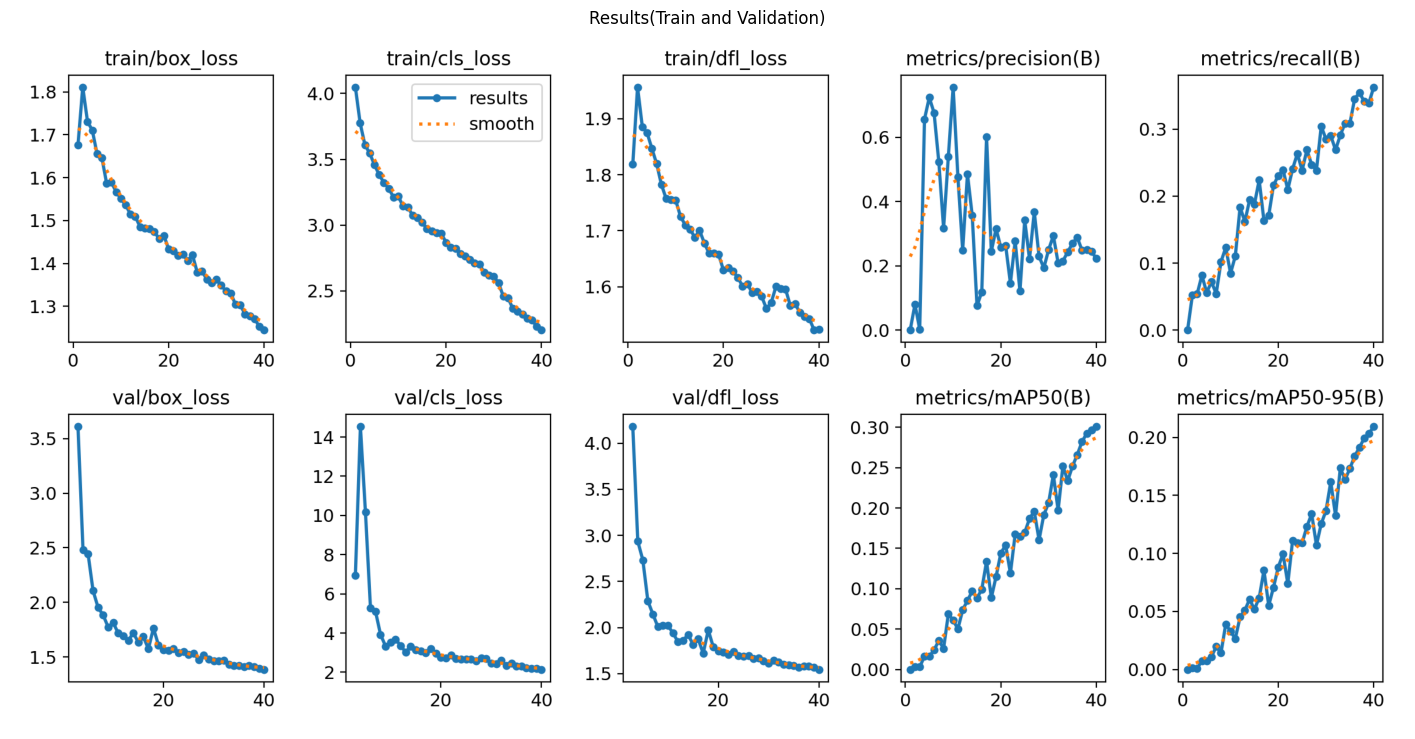

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "/content/runs/detect/train/results.png"  # your file
img = Image.open(img_path)

plt.figure(figsize=(18, 18))
plt.imshow(img)
plt.axis("off")
plt.title("Results(Train and Validation)")
plt.show()

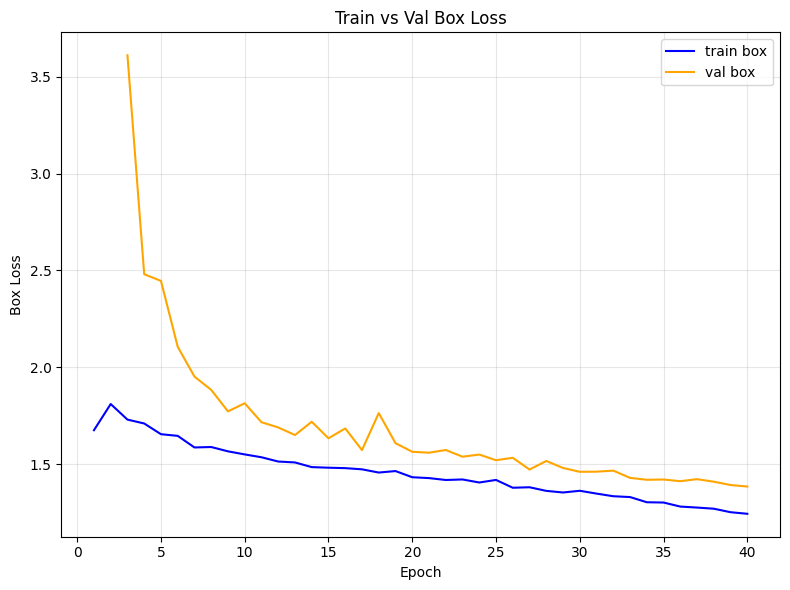

Saved: /content/runs/detect/train/train_vs_val_box_loss.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# CHANGE THIS to your run dir
RUN = Path("/content/runs/detect/train")

# Read the results from the CSV file
df = pd.read_csv(RUN / "results.csv")
x = df["epoch"] if "epoch" in df.columns else range(len(df))

# Create the plot for Train vs Val Box Loss
plt.figure(figsize=(8, 6))

# Plot train and val box loss
plt.plot(x, df["train/box_loss"], label="train box", color='blue')
plt.plot(x, df["val/box_loss"], label="val box", color='orange')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Box Loss")
plt.title("Train vs Val Box Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# Save the image to your results folder
out_path = RUN / "train_vs_val_box_loss.png"
plt.tight_layout()
plt.savefig(out_path, dpi=200)

# Display the plot
plt.show()

print("Saved:", out_path)


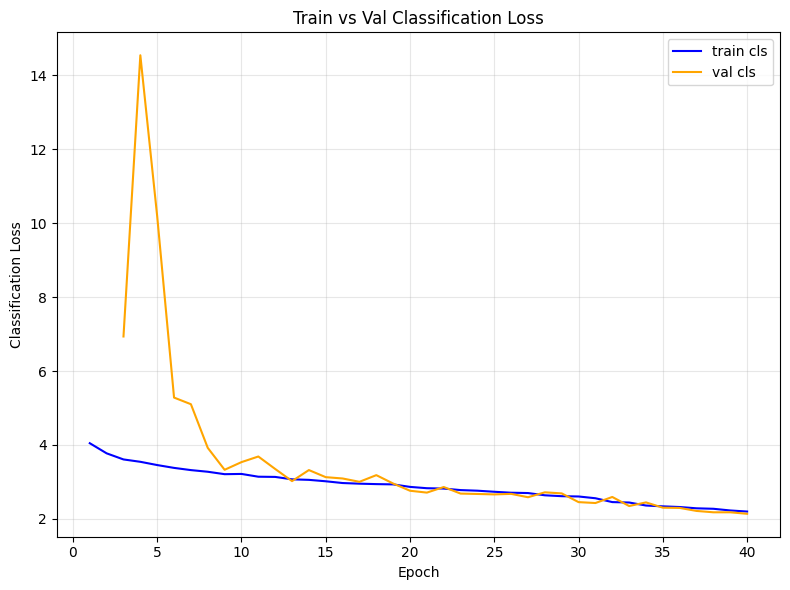

Saved: /content/runs/detect/train/train_vs_val_cls_loss.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# CHANGE THIS to your run dir
RUN = Path("/content/runs/detect/train/")

# Read the results from the CSV file
df = pd.read_csv(RUN / "results.csv")
x = df["epoch"] if "epoch" in df.columns else range(len(df))

# Create the plot for Train vs Val Classification Loss
plt.figure(figsize=(8, 6))

# Plot train and val classification loss
plt.plot(x, df["train/cls_loss"], label="train cls", color='blue')
plt.plot(x, df["val/cls_loss"], label="val cls", color='orange')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Classification Loss")
plt.title("Train vs Val Classification Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# Save the image to your results folder
out_path = RUN / "train_vs_val_cls_loss.png"
plt.tight_layout()
plt.savefig(out_path, dpi=200)

# Display the plot
plt.show()

print("Saved:", out_path)


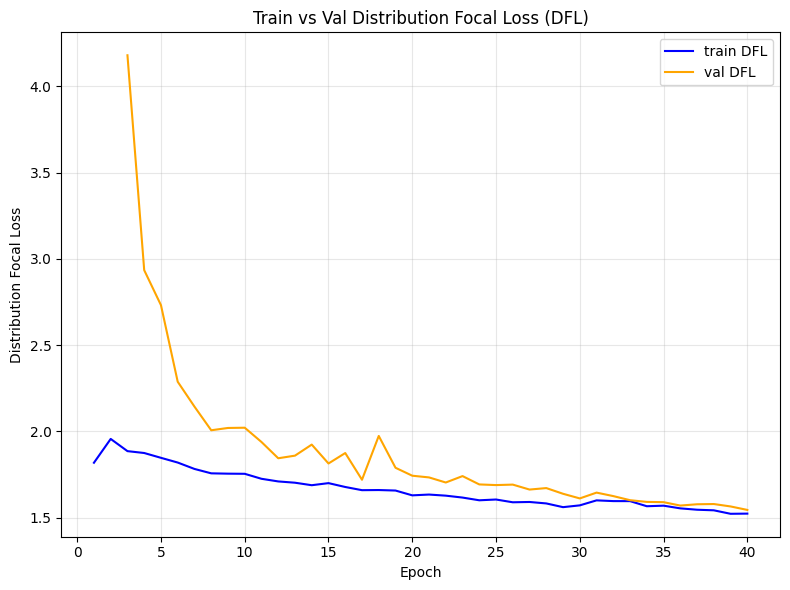

Saved: /content/runs/detect/train/train_vs_val_dfl_loss.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# CHANGE THIS to your run dir
RUN = Path("/content/runs/detect/train")

# Read the results from the CSV file
df = pd.read_csv(RUN / "results.csv")
x = df["epoch"] if "epoch" in df.columns else range(len(df))

# Create the plot for Train vs Val DFL Loss (Distribution Focal Loss)
plt.figure(figsize=(8, 6))

# Plot train and val DFL loss
plt.plot(x, df["train/dfl_loss"], label="train DFL", color='blue')
plt.plot(x, df["val/dfl_loss"], label="val DFL", color='orange')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Distribution Focal Loss")
plt.title("Train vs Val Distribution Focal Loss (DFL)")
plt.legend()
plt.grid(True, alpha=0.3)

# Save the image to your results folder
out_path = RUN / "train_vs_val_dfl_loss.png"
plt.tight_layout()
plt.savefig(out_path, dpi=200)

# Display the plot
plt.show()

print("Saved:", out_path)


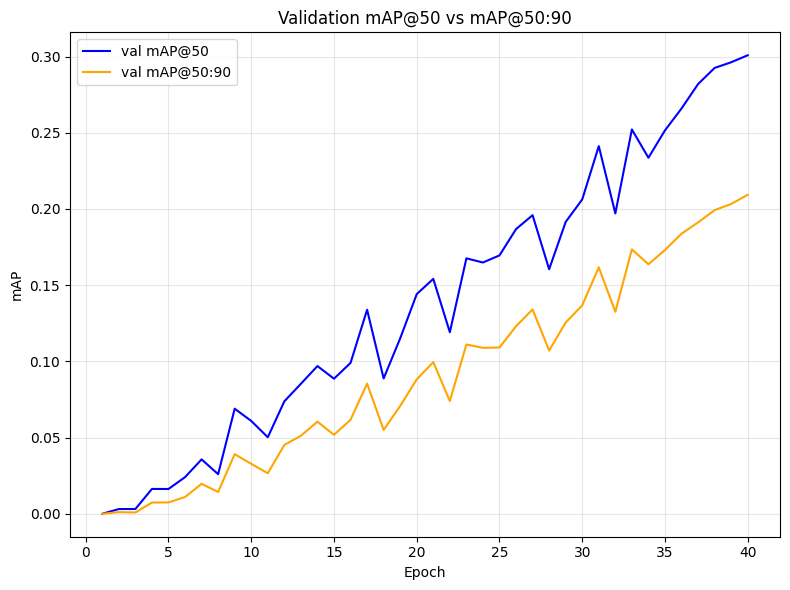

Saved: /content/runs/detect/train/val_mAP50_vs_mAP50_95.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# CHANGE THIS to your run dir
RUN = Path("/content/runs/detect/train")

# Read the results from the CSV file
df = pd.read_csv(RUN / "results.csv")
x = df["epoch"] if "epoch" in df.columns else range(len(df))

# Create the plot for Val mAP@50 and mAP@50:90
plt.figure(figsize=(8, 6))

# Plot val mAP@50 and val mAP@50:90 (use correct columns for val mAP)
plt.plot(x, df['metrics/mAP50(B)'], label="val mAP@50", color='blue')  # Validation mAP@50
plt.plot(x, df['metrics/mAP50-95(B)'], label="val mAP@50:90", color='orange')  # Validation mAP@50:95

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("Validation mAP@50 vs mAP@50:90")
plt.legend()
plt.grid(True, alpha=0.3)

# Save the image to your results folder
out_path = RUN / "val_mAP50_vs_mAP50_95.png"
plt.tight_layout()
plt.savefig(out_path, dpi=200)

# Display the plot
plt.show()

print("Saved:", out_path)


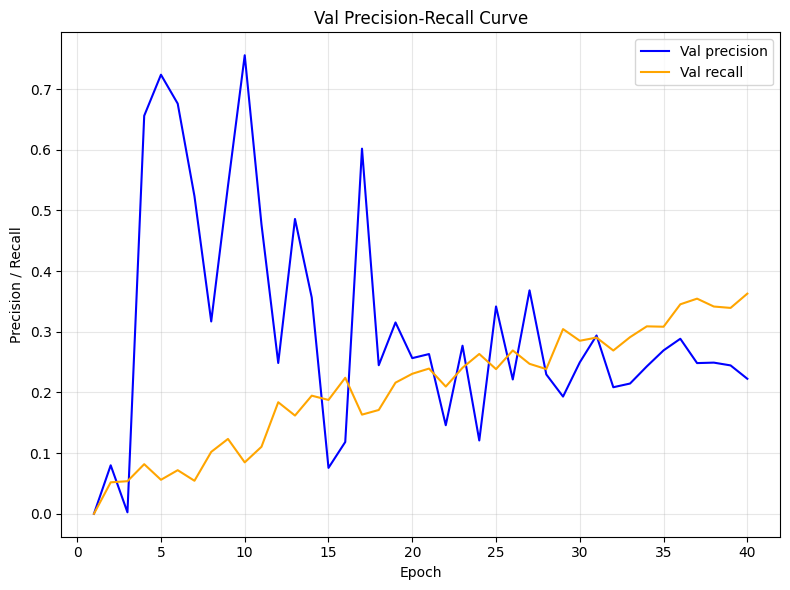

Saved: /content/runs/detect/train/train_vs_val_pr_curve.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# CHANGE THIS to your run dir
RUN = Path("/content/runs/detect/train")

# Read the results from the CSV file
df = pd.read_csv(RUN / "results.csv")
x = df["epoch"] if "epoch" in df.columns else range(len(df))

# Create the plot for Train Precision-Recall Curve
plt.figure(figsize=(8, 6))

# Plot train PR (Precision-Recall) curve
plt.plot(x, df["metrics/precision(B)"], label="Val precision", color='blue')
plt.plot(x, df["metrics/recall(B)"], label="Val recall", color='orange')

# Set labels and title
plt.xlabel("Epoch")
plt.ylabel("Precision / Recall")
plt.title("Val Precision-Recall Curve")
plt.legend()
plt.grid(True, alpha=0.3)

# Save the image to your results folder
out_path = RUN / "train_vs_val_pr_curve.png"
plt.tight_layout()
plt.savefig(out_path, dpi=200)

# Display the plot
plt.show()

print("Saved:", out_path)


In [ ]:
from ultralytics import YOLO

DATA = "/content/data.yaml"                 # must contain a `test:` entry
WEIGHTS = "runs/detect/train/weights/best.pt"

model = YOLO(WEIGHTS)

# Evaluate on TEST ONLY (requires test labels)
metrics = model.val(
    data=DATA,
    split='test',        # <-- key line
    imgsz=640,
    conf=0.25,
    iou=0.50,
    plots=True           # saves confusion_matrix.png and other plots
)
print(metrics)  # mAP, precision/recall, etc.


Ultralytics 8.3.189 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,561,993 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 872.4±198.9 MB/s, size: 25.8 KB)
val: Scanning /content/test/labels... 238 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 238/238 2061.6it/s 0.1s
val: New cache created: /content/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 3.5it/s 4.3s
                   all        238        454      0.253      0.314      0.295       0.24
       Apple Scab Leaf         10         13       0.75      0.231        0.5      0.421
            Apple leaf          9         10      0.189        0.7      0.419      0.316
       Apple rust leaf         10         11          0          0          0          0
      Bell_pepper leaf          8         11          0          0          0          0
 Bell_pep

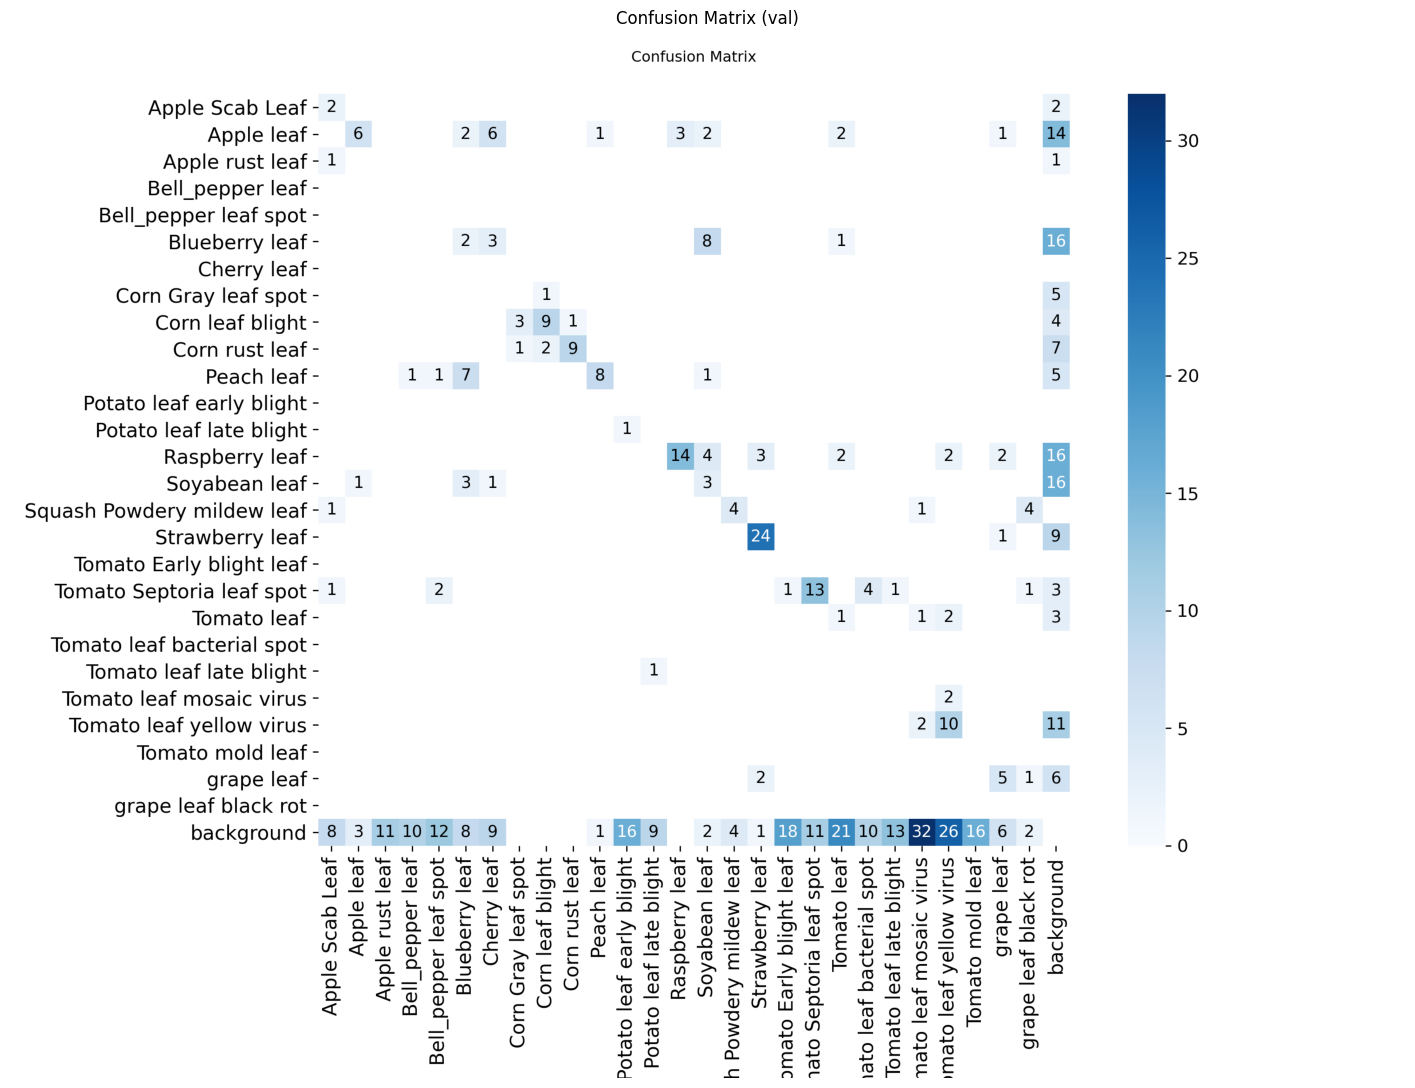

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "/content/runs/detect/val/confusion_matrix.png"  # your file
img = Image.open(img_path)

plt.figure(figsize=(18, 18))
plt.imshow(img)
plt.axis("off")
plt.title("Confusion Matrix (val)")
plt.show()
